# **1. BUILD CLASS MODEL**

In [6]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.8 MB/s eta 0:00:00


In [7]:
import pandas as pd
import numpy as np
import joblib
import logging
import json
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, PredefinedSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler

In [10]:
class ModelTrainer:
    """
    Quản lý pipeline huấn luyện ML: tiền xử lý dữ liệu, feature selection,
    chia train/val, train model, và đánh giá kết quả. Bao gồm logger tích hợp.
    """
    def __init__(self, model_type="rf", params=None, random_state=42):
        """
        Khởi tạo ModelTrainer với loại mô hình, tham số và random state.
        Thiết lập logger ghi ra file và console.
        """
        self.model_type = model_type
        self.params = params or {}
        self.random_state = random_state
        random.seed(random_state)
        np.random.seed(random_state)

        self.label_encoder = None
        self.pipeline = None
        self.selector = None


        # Logger: vừa ghi ra file, vừa hiển thị console
        self.logger = logging.getLogger(__name__)
        if not self.logger.handlers:
            log_path = "/content/training.log"
            self.log_path = log_path

            self.logger.setLevel(logging.INFO)

            # File handler
            fh = logging.FileHandler(log_path)
            fh.setLevel(logging.INFO)
            fh.setFormatter(logging.Formatter("%(asctime)s - %(levelname)s - %(message)s"))

            # Console handler
            ch = logging.StreamHandler()
            ch.setLevel(logging.INFO)
            ch.setFormatter(logging.Formatter("%(asctime)s - %(levelname)s - %(message)s"))

            self.logger.addHandler(fh)
            self.logger.addHandler(ch)


    # ============================================================
    # Properties
    # ============================================================
    @property
    def class_names(self):
        """Danh sách tên các lớp target sau khi encode. None nếu chưa fit."""
        if self.label_encoder:
            return list(self.label_encoder.classes_)
        return None

    @property
    def num_features(self):
        """Số lượng feature (không tính target) trong dataframe."""
        return self.df.drop(columns=[self.target_col]).shape[1]



    # =========================
    # 1. Load dataset
    #=========================
    def load_data(self, df, target_col):
        """
Load dataset vào ModelTrainer và xác định cột target.
Sao chép df để giữ nguyên dữ liệu gốc; logger ghi thông tin shape.
        """
        self.df = df.copy()
        self.target_col = target_col
        self.logger.info(f"Data loaded with shape {self.df.shape}")


    # =========================
    # 2. Feature Generation
    # =========================
    @staticmethod
    def feature_generation(df):
        """
   Tạo các feature mới từ DataFrame: tổng tần suất (freq), tỷ lệ chấp nhận (accept_rate),
    nhóm thu nhập, nhóm tuổi, và nhóm thời gian trong ngày (nếu cột 'time' tồn tại).
   Trả về DataFrame sao chép, không làm thay đổi dữ liệu gốc.
        """
        df = df.copy()

        # freq
        if {"fb_freq", "tik_freq", "yt_freq"}.issubset(df.columns):
            df["freq"] = df["fb_freq"] + df["tik_freq"] + df["yt_freq"]

        # Accept Rate
        df["accept_rate"] = df["number_of_accept"] / df["number_of_suggestions"]
        df["accept_rate"] = df["accept_rate"].fillna(0)

        # income bins
        if "income" in df.columns:
            df["Smaller_than_6M"] = (df["income"] < 6_000_000).astype(int)
            df["6M_to_12M"] = df["income"].between(6_000_000, 12_000_000 - 1).astype(int)
            df["12M_to_20M"] = df["income"].between(12_000_000, 20_000_000 - 1).astype(int)
            df["Higher_than_20M"] = (df["income"] >= 20_000_000).astype(int)

        #  Age Group: 18-25, 25-31, 31-41, 41+.
        df["age_group"] = pd.cut(
            df["age"],
            bins=[18, 25, 31, 41, 200],   # 200 để đảm bảo nhận mọi giá trị > 41
            labels=["18-25", "25-31", "31-41", "41+"],
            right=False  # khoảng trái đóng, phải mở: [18,25)
        )

        # time buckets
        if "time" in df.columns:
            df["time_parsed"] = pd.to_datetime(df["time"], format="%H:%M", errors="coerce")
            df["hour"] = df["time_parsed"].dt.hour
            df["time_morning"] = df["hour"].between(5, 11).astype(int)
            df["time_afternoon"] = df["hour"].between(12, 16).astype(int)
            df["time_evening"] = df["hour"].between(17, 20).astype(int)
            df["time_night"] = ((df["hour"] >= 21) | (df["hour"] <= 4)).astype(int)
            df.drop(columns=["time_parsed", "hour"], errors="ignore", inplace=True)

        return df

    # =========================
    # 3. Preprocess categorical features, numerical & encode target
    # =========================
    def preprocess(self, cat_cols=None):
        """
Tiền xử lý dữ liệu: encode target, xác định cột categorical/numerical, tạo preprocessor.
Cập nhật self.df, self.label_encoder, self.cat_cols, self.num_cols, self.preprocessor.
Scaler chỉ áp dụng cho lr/svm; logger ghi thông tin cột và scaler.
        """
        df = self.df.copy()

        # Encode target
        self.label_encoder = LabelEncoder()
        df[self.target_col] = self.label_encoder.fit_transform(df[self.target_col])

        # categorical
        if cat_cols is None:
            cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
            if self.target_col in cat_cols:
                cat_cols.remove(self.target_col)

        self.cat_cols = cat_cols

        # numerical columns
        self.num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        if self.target_col in self.num_cols:
            self.num_cols.remove(self.target_col)

        # quyết định có scale hay không (chỉ scaler các mô hình nhất định lr, svm)
        if self.model_type in ["lr", "svm"]:
            num_transformer = StandardScaler()
        else:  # RF, XGB, LGBM, CatBoost
            num_transformer = "passthrough"

        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', num_transformer, self.num_cols),
                ('cat', OneHotEncoder(handle_unknown='ignore'), self.cat_cols)
            ]
        )

        self.df = df
        self.logger.info(f"Preprocessing created. Will be fitted inside the pipeline. Categorical cols: {self.cat_cols}, Numerical cols: {self.num_cols}, Scaler applied: {num_transformer != 'passthrough'}")

    # =========================
    # 4. FEATURE SELECTION
    # =========================
    def feature_selection(self, method="kbest", k_best=30, estimator=None):
        """
    Tạo feature selector (SelectKBest hoặc RFE) và lưu vào self.selector.
    Logger ghi phương pháp, số feature và estimator (nếu RFE). Chưa fit dữ liệu.
        """
        if method == "kbest":
            self.selector = SelectKBest(score_func=f_classif, k=k_best)
            self.logger.info(f"[FS] Method: SelectKBest | k={k_best} | score_func=f_classif")

        elif method == "rfe":
            if estimator is None:
                estimator = RandomForestClassifier(random_state=self.random_state)
            self.selector = RFE(estimator=estimator, n_features_to_select=k_best)
            self.logger.info(f"[FS] Method: RFE | k={k_best} | estimator={estimator.__class__.__name__}")
        else:
            raise ValueError("method must be 'kbest' or 'rfe'")

        self.logger.info("[FS] Selector created. Will be fitted inside the pipeline.")


    # =========================
    # 5. Split train/val
    # =========================
    def split_train_val(self, val_size=0.2):
        """
      Chia dataset thành train/validation theo tỷ lệ val_size, stratify theo target.
      Cập nhật self.X_train, self.X_val, self.y_train, self.y_val; logger ghi kích thước.
        """
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            self.df.drop(columns=[self.target_col]),
            self.df[self.target_col],
            test_size=val_size,
            stratify=self.df[self.target_col],
            random_state=self.random_state
        )
        self.logger.info(f"Train shape: {self.X_train.shape}, Val shape: {self.X_val.shape}")

    # =========================
    # 6. DOWN SAMPLE
    # =========================
    def downsample(self):
        """
    Cân bằng các lớp trong tập huấn luyện bằng cách giảm các lớp lớn về cùng kích thước lớp nhỏ nhất.
    Cập nhật self.X_train và self.y_train; logger ghi số lượng trước/sau.
        """
        df_train = pd.concat([self.X_train, self.y_train], axis=1)
        min_size = df_train[self.target_col].value_counts().min()

        df_balanced = (
            df_train.groupby(self.target_col)
            .apply(lambda x: x.sample(min_size, replace=False, random_state=self.random_state))
            .reset_index(drop=True)
        )

        self.X_train = df_balanced.drop(self.target_col, axis=1)
        self.y_train = df_balanced[self.target_col]

        before = df_train[self.target_col].value_counts().to_dict()
        after = self.y_train.value_counts().to_dict()

        self.logger.info(f"Downsample completed. Before: {before} | After: {after}")


    # 7. Build pipeline — đã hỗ trợ nhiều model
    # ============================================================
    def build_pipeline(self):
        """
      Xây dựng sklearn Pipeline gồm preprocessor, optional selector, và classifier
      dựa trên self.model_type và self.params. Cập nhật self.pipeline và ghi log các bước.
        """
        if self.model_type == "lr":
            clf = LogisticRegression(max_iter=500, random_state=self.random_state, **self.params)

        elif self.model_type == "svm":
            clf = SVC(probability=True, random_state=self.random_state, **self.params)

        elif self.model_type == "rf":
            clf = RandomForestClassifier(random_state=self.random_state, **self.params)

        elif self.model_type == "lgbm":
            clf = LGBMClassifier(random_state=self.random_state, **self.params)

        elif self.model_type == "xgb":
            clf = XGBClassifier(
                objective="multi:softprob",
                eval_metric="mlogloss",
                random_state=self.random_state,
                **self.params
            )

        elif self.model_type=="cat":
            clf = CatBoostClassifier(random_state=self.random_state, verbose=0, **self.params)
        else:
            raise ValueError(f"Model type '{self.model_type}' chưa hỗ trợ!")

        steps = [('preprocessor', self.preprocessor)]

        if self.selector is not None:
            steps.append(('selector', self.selector))

        steps.append(('classifier', clf))

        self.pipeline = Pipeline(steps)
        self.logger.info(f"Pipeline built successfully. Steps: {list(self.pipeline.named_steps.keys())}")


    # =========================
    # 8. Train
    # =========================
    def train(self):
        """
    Huấn luyện pipeline trên self.X_train và self.y_train.
    Logger ghi số lượng samples, model sử dụng và thời gian training.
        """
        self.logger.info(f"Training started on {self.X_train.shape[0]} samples using model={self.model_type.upper()}.")
        start = time.time()

        self.pipeline.fit(self.X_train, self.y_train)

        duration = time.time() - start
        self.logger.info(f"Training completed in {duration:.2f} seconds.")


    # =========================
    # 9. Optimize hyperparameters
    # =========================
    def optimize_params(self, param_grid, search="grid", n_iter=20, scoring="f1_macro"):
        """
    Tối ưu hyperparameters của pipeline bằng GridSearchCV hoặc RandomizedSearchCV.
    Cập nhật self.pipeline với best estimator; logger ghi phương pháp, scoring và best params.
        """
        if self.pipeline is None:
            raise ValueError("Gọi build_pipeline() trước khi optimize")

        self.logger.info(f"Hyperparameter search started. Method={search.upper()}, Scoring={scoring}")

        test_fold = [-1]*len(self.X_train) + [0]*len(self.X_val)
        X_combined = pd.concat([self.X_train, self.X_val], axis=0)
        y_combined = pd.concat([self.y_train, self.y_val], axis=0)
        ps = PredefinedSplit(test_fold=test_fold)

        param_grid = {f"classifier__{k}": v for k, v in param_grid.items()}

        if search == "grid":
            searcher = GridSearchCV(
                self.pipeline,
                param_grid=param_grid,
                scoring=scoring,
                cv=ps,
                n_jobs=-1,
                verbose=1
            )
        else:
            searcher = RandomizedSearchCV(
                self.pipeline,
                param_distributions=param_grid,
                n_iter=n_iter,
                scoring=scoring,
                cv=ps,
                n_jobs=-1,
                random_state=self.random_state,
                verbose=1
            )

        searcher.fit(X_combined, y_combined)
        self.pipeline = searcher.best_estimator_
        self.logger.info(f"Hyperparameter optimization completed. Best params: {searcher.best_params_}")
        print("Best params:", searcher.best_params_)

    # =========================
    # 10. Evaluate (với ROC curve multi-class)
    # =========================
    def evaluate(self, X=None, y=None, plot_cm=True, plot_roc=True):
        """
    Đánh giá pipeline trên tập dữ liệu test (mặc định self.X_test, self.y_test).
    Tính accuracy, F1-macro, precision, recall; in classification report.
    Tùy chọn hiển thị confusion matrix và ROC curve đa lớp.
    Trả về dict chứa các metric.
        """
        self.logger.info("Evaluation started...")
        X_test = self.X_test if X is None else X
        y_test = self.y_test if y is None else y

        y_pred = self.pipeline.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')

        self.logger.info(
            f"Evaluation results - "
            f"Accuracy={acc:.4f}, F1-macro={f1:.4f}, "
            f"Precision={precision:.4f}, Recall={recall:.4f}"
        )
        print(f"Accuracy: {acc:.3f}, F1-macro: {f1:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}")

        print(classification_report(
            y_test, y_pred,
            target_names=self.label_encoder.classes_
        ))

        # =========================
        # Confusion matrix
        # =========================
        if plot_cm:
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(8,6))
            sns.heatmap(cm, annot=True, cmap="Blues",
                    xticklabels=self.label_encoder.classes_,
                    yticklabels=self.label_encoder.classes_)
            plt.title("Confusion Matrix")
            plt.show()

        # =========================
        # ROC curve multi-class
        # =========================
        if plot_roc:
            # One-hot encode target
            y_bin = label_binarize(y_test, classes=range(len(self.label_encoder.classes_)))

            if hasattr(self.pipeline, "predict_proba"):
                y_score = self.pipeline.predict_proba(X_test)
            else:
                y_score = self.pipeline.decision_function(X_test)

            n_classes = y_bin.shape[1]

            plt.figure(figsize=(10, 8))
            for i in range(n_classes):
                fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, lw=2, label=f'{self.label_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve - Multi-class')
            plt.legend(loc='lower right')
            plt.show()

        return {"accuracy": acc, "f1_macro": f1, "precision": precision, "recall": recall}

    # 11. Hàm chạy tất cả các model
    def run_models(self, df_train, df_test, target_col, models, k_best=40, param_grids=None, search="grid", n_iter=20, save_path=None, top_n_features=20):
        """
Chạy pipeline đầy đủ cho nhiều model: train, optimize (nếu có), evaluate trên test set.
Trả về dict kết quả metric của từng model; có thể lưu CSV/JSON.
        """
        results = {}

        for model_name in models:
            print(f"\n===== Running model: {model_name} =====")
            self.logger.info(f"========== Running model: {model_name} ==========")

            self.model_type = model_name
            self.params = {}  # reset params

            # =========================
            # FEATURE GENERATION
            # =========================
            train_gen = self.feature_generation(df_train)
            test_gen = self.feature_generation(df_test)

            # =========================
            # LOAD TRAIN (only once)
            # =========================
            self.load_data(train_gen, target_col=target_col)

            # =========================
            # Preprocess + Select + Split + Downsample + Build + Train
            # =========================
            self.preprocess()
            self.feature_selection(k_best=k_best)
            self.split_train_val()
            self.downsample()

            self.build_pipeline()
            self.train()

            # =========================
            # Optimize params (optional)
            # =========================
            optimized = False
            if param_grids:
                # TH1: param_grids = {param1:[], param2:[]}
                if isinstance(param_grids, dict) and all(isinstance(v, list) for v in param_grids.values()):
                    self.optimize_params(param_grids, search=search, n_iter=n_iter)
                    optimized = True

                # TH2: param_grids = {"rf": {...}, "xgb": {...}}
                elif model_name in param_grids:
                    self.optimize_params(param_grids[model_name], search=search, n_iter=n_iter)
                    optimized = True

            # =========================
            # Train lại sau optimize
            # =========================
            # Retrain trên toàn bộ train + val với params đã tối ưu
            # =========================
            if optimized:
                self.logger.info(f"Retraining {model_name} on full train+val with best params...")
                # Kết hợp train + val
                X_full = pd.concat([self.X_train, self.X_val])
                y_full = pd.concat([self.y_train, self.y_val])

                # pipeline đã được optimize nên fit lại trên toàn bộ dữ liệu
                self.pipeline.fit(X_full, y_full)
                self.logger.info(f"{model_name} retrained on full train+val successfully.")



            # =========================
            # Prepare test
            # =========================
            # Không dùng load_data -> tránh reset pipeline
            self.df = test_gen.copy()
            self.preprocess()

            self.X_test = self.df.drop(columns=[target_col])
            self.y_test = self.df[target_col]

            # =========================
            # Evaluate
            # =========================
            metrics = self.evaluate()
            results[model_name] = metrics

        # =========================
        # SAVE RESULTS
        # =========================
        if save_path:
            if save_path.endswith(".csv"):
                df_results = pd.DataFrame(results).T.reset_index()
                df_results.rename(columns={'index': 'model'}, inplace=True)
                df_results.to_csv(save_path, index=False)

            elif save_path.endswith(".json"):
                with open(save_path, "w") as f:
                    json.dump(results, f, indent=4)

            print(f"Results saved to {save_path}")

        print("\n===== All models results =====")
        for model, metric in results.items():
            print(f"{model}: {metric}")

        return results


    # 12. Save model
    def save_model(self, path="model.pkl"):
        """
    Lưu pipeline hiện tại vào file bằng joblib. Logger ghi thông tin đường dẫn.
        """
        joblib.dump(self.pipeline, path)
        self.logger.info(f"Model saved to {path}")

    # 13. Load model
    def load_model(self, path="model.pkl"):
        """
    Tải pipeline từ file bằng joblib và cập nhật self.pipeline. Logger ghi thông tin đường dẫn.
        """
        self.pipeline = joblib.load(path)
        self.logger.info(f"Model loaded from {path}")
        return self.pipeline

# **2. ÁP DỤNG MÔ HÌNH CHO DATA**

In [ ]:
# Load dữ liệu
df_train = pd.read_csv('/content/data_train_cleaned.csv')
df_test = pd.read_csv('/content/data_test_cleaned.csv')
# Lọc chỉ lấy number_of_accept = 1
df_train = df_train[df_train['number_of_accept']==1].copy()
df_test = df_test[df_test['number_of_accept']==1].copy()

In [ ]:
trainer = ModelTrainer(random_state=42)
models_to_try = ["lr", "svm", "rf", "lgbm", "xgb","cat"]

# Define parameter grids for each model type
lr_param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'solver': ['lbfgs'], # 'lbfgs' is default, good for multiclass
    'max_iter': [500]
}

svm_param_grid = {
    'C': [0.1, 1.0, 10.0],
    'gamma': ['scale', 0.01, 0.1],
    'kernel': ['rbf'] # radial basis function kernel is common
}

rf_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

lgbm_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [-1, 10, 20],
    'num_leaves': [20, 31, 50],
    'learning_rate': [0.01, 0.05, 0.1]
}

xgb_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9]
}

cat_param_grid = {
    'iterations': [100, 300, 500],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5]
}

# Combine all model-specific parameter grids into one dictionary
param_grids_all_models = {
    "lr": lr_param_grid,
    "svm": svm_param_grid,
    "rf": rf_param_grid,
    "lgbm": lgbm_param_grid,
    "xgb": xgb_param_grid,
    "cat": cat_param_grid
}


2025-12-10 18:20:18,921 - INFO - ========== Running model: lr ==========
INFO:__main__:========== Running model: lr ==========
2025-12-10 18:20:19,007 - INFO - Data loaded with shape (5382, 44)
INFO:__main__:Data loaded with shape (5382, 44)
2025-12-10 18:20:19,021 - INFO - Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'education', 'profession', 'living_with', 'nation', 'phone', 'job', 'marriage_status', 'purpose', 'go_with', 'weather', 'time', 'age_group'], Numerical cols: ['id', 'age', 'income', 'fb_freq', 'yt_freq', 'tik_freq', 'use_less_than_2GB', 'use_2GB_to_4GB', 'number_child', 'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'to_hanoi', 'to_other', 'score', 'number_of_suggestions', 'number_of_plans', 'number_of_accept', 'number_of_accept_2', 'freq', 'accept_rate', 'Smaller_than_6M', '6M_to_12M', '12M_to_20M', 'Higher_than_20M', 'time_morning', 'time_afternoon', 'time_evening', 'time_night'], Scaler applied: True
INFO:__main__:Pre

Kết quả chạy tất cả các mô hình với phương pháp grid_search và SelectKbest:

===== Running model: lr =====


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
2025-12-10 18:20:19,617 - INFO - Training completed in 0.49 seconds.
INFO:__main__:Training completed in 0.49 seconds.
2025-12-10 18:20:19,621 - INFO - Hyperparameter search started. Method=GRID, Scoring=f1_macro
INFO:__main__:Hyperparameter search started. Method=GRID, Scoring=f1_macro


Fitting 1 folds for each of 4 candidates, totalling 4 fits


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
2025-12-10 18:20:21,479 - INFO - Hyperparameter optimization completed. Best params: {'classifier__C': 0.1, 'classifier__max_iter': 500, 'classifier__solver': 'lbfgs'}
INFO:__main__:Hyperparameter optimization completed. Best params: {'classifier__C': 0.1, 'classifier__max_iter': 500, 'classifier__solver': 'lbfgs'}
2025-12-10 18:20:21,489 - INFO - Retraining lr on full train+val with best params...
INFO:__main__:Retraining lr on full train+val with best params...
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0 0 0 0 0 0] are cons

Best params: {'classifier__C': 0.1, 'classifier__max_iter': 500, 'classifier__solver': 'lbfgs'}


2025-12-10 18:20:22,024 - INFO - lr retrained on full train+val successfully.
INFO:__main__:lr retrained on full train+val successfully.
2025-12-10 18:20:22,037 - INFO - Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'education', 'profession', 'living_with', 'nation', 'phone', 'job', 'marriage_status', 'purpose', 'go_with', 'weather', 'time', 'age_group'], Numerical cols: ['id', 'age', 'income', 'fb_freq', 'yt_freq', 'tik_freq', 'use_less_than_2GB', 'use_2GB_to_4GB', 'number_child', 'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'to_hanoi', 'to_other', 'score', 'number_of_suggestions', 'number_of_plans', 'number_of_accept', 'number_of_accept_2', 'freq', 'accept_rate', 'Smaller_than_6M', '6M_to_12M', '12M_to_20M', 'Higher_than_20M', 'time_morning', 'time_afternoon', 'time_evening', 'time_night'], Scaler applied: True
INFO:__main__:Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'education',

Accuracy: 0.429, F1-macro: 0.390, Precision: 0.415, Recall: 0.386
                 precision    recall  f1-score   support

       DATACALL       0.39      0.19      0.25        37
       DATAGOLD       0.33      0.34      0.34        38
     DATASILVER       0.60      0.61      0.60       111
    SOCIALMEDIA       0.43      0.33      0.37       113
SOCIALMEDIAGOLD       0.33      0.46      0.38       102

       accuracy                           0.43       401
      macro avg       0.41      0.39      0.39       401
   weighted avg       0.44      0.43      0.42       401



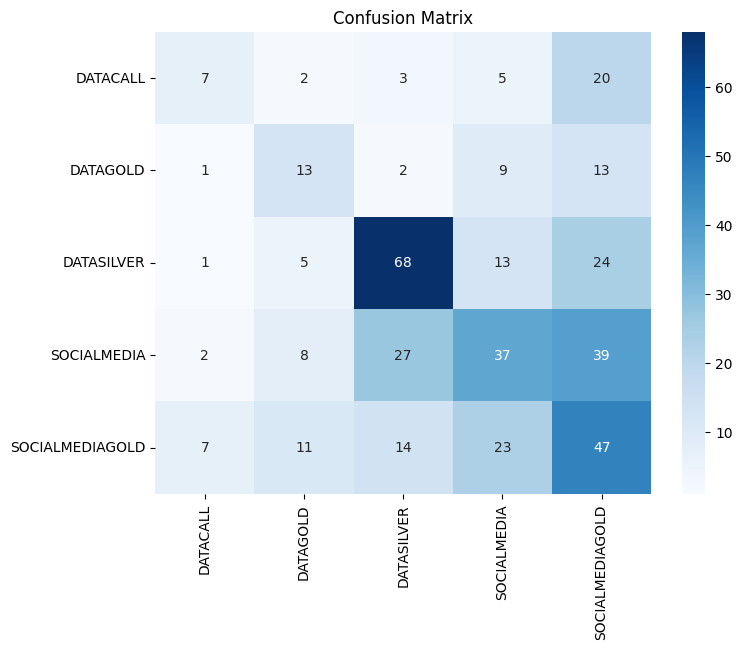

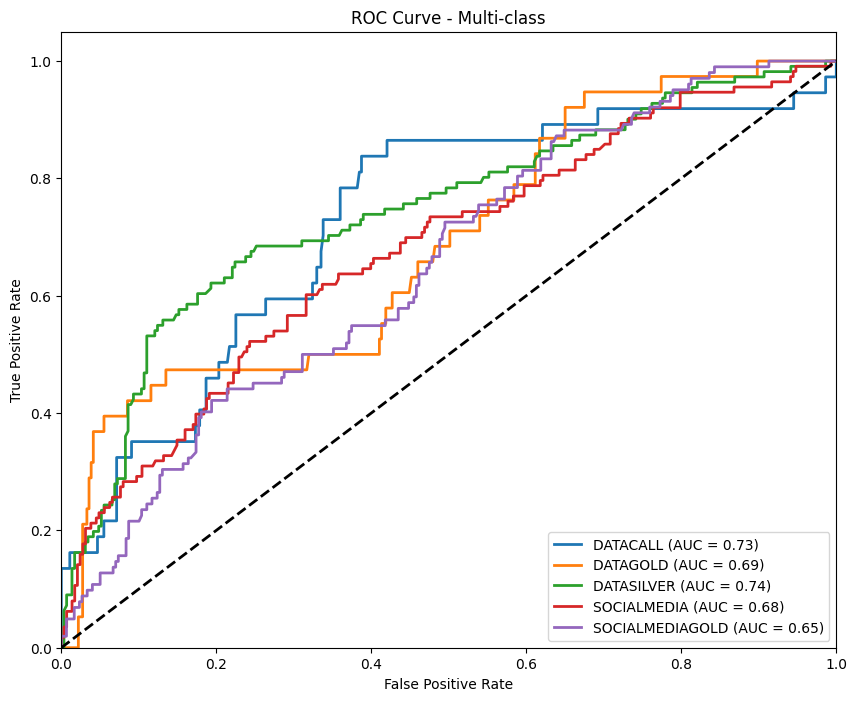

2025-12-10 18:20:23,077 - INFO - ========== Running model: svm ==========
INFO:__main__:========== Running model: svm ==========
2025-12-10 18:20:23,187 - INFO - Data loaded with shape (5382, 44)
INFO:__main__:Data loaded with shape (5382, 44)
2025-12-10 18:20:23,212 - INFO - Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'education', 'profession', 'living_with', 'nation', 'phone', 'job', 'marriage_status', 'purpose', 'go_with', 'weather', 'time', 'age_group'], Numerical cols: ['id', 'age', 'income', 'fb_freq', 'yt_freq', 'tik_freq', 'use_less_than_2GB', 'use_2GB_to_4GB', 'number_child', 'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'to_hanoi', 'to_other', 'score', 'number_of_suggestions', 'number_of_plans', 'number_of_accept', 'number_of_accept_2', 'freq', 'accept_rate', 'Smaller_than_6M', '6M_to_12M', '12M_to_20M', 'Higher_than_20M', 'time_morning', 'time_afternoon', 'time_evening', 'time_night'], Scaler applied: True
INFO:__main__:P


===== Running model: svm =====


2025-12-10 18:20:23,291 - INFO - Train shape: (4305, 43), Val shape: (1077, 43)
INFO:__main__:Train shape: (4305, 43), Val shape: (1077, 43)
/tmp/ipython-input-1345220334.py:190: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min_size, replace=False, random_state=self.random_state))
2025-12-10 18:20:23,320 - INFO - Downsample completed. Before: {3: 1158, 2: 1137, 4: 1018, 0: 542, 1: 450} | After: {0: 450, 1: 450, 2: 450, 3: 450, 4: 450}
INFO:__main__:Downsample completed. Before: {3: 1158, 2: 1137, 4: 1018, 0: 542, 1: 450} | After: {0: 450, 1: 450, 2: 450, 3: 450, 4: 450}
2025-12-10 18:20:23,325 - INFO - Pipeline built successfully. Steps: ['preprocessor', 'selector', 'cl

Fitting 1 folds for each of 9 candidates, totalling 9 fits


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
2025-12-10 18:21:00,394 - INFO - Hyperparameter optimization completed. Best params: {'classifier__C': 10.0, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
INFO:__main__:Hyperparameter optimization completed. Best params: {'classifier__C': 10.0, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
2025-12-10 18:21:00,397 - INFO - Retraining svm on full train+val with best params...
INFO:__main__:Retraining svm on full train+val with best params...
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0 0 0 0 0 0] are co

Best params: {'classifier__C': 10.0, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}


2025-12-10 18:21:06,311 - INFO - svm retrained on full train+val successfully.
INFO:__main__:svm retrained on full train+val successfully.
2025-12-10 18:21:06,320 - INFO - Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'education', 'profession', 'living_with', 'nation', 'phone', 'job', 'marriage_status', 'purpose', 'go_with', 'weather', 'time', 'age_group'], Numerical cols: ['id', 'age', 'income', 'fb_freq', 'yt_freq', 'tik_freq', 'use_less_than_2GB', 'use_2GB_to_4GB', 'number_child', 'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'to_hanoi', 'to_other', 'score', 'number_of_suggestions', 'number_of_plans', 'number_of_accept', 'number_of_accept_2', 'freq', 'accept_rate', 'Smaller_than_6M', '6M_to_12M', '12M_to_20M', 'Higher_than_20M', 'time_morning', 'time_afternoon', 'time_evening', 'time_night'], Scaler applied: True
INFO:__main__:Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'education

Accuracy: 0.576, F1-macro: 0.538, Precision: 0.536, Recall: 0.544
                 precision    recall  f1-score   support

       DATACALL       0.31      0.27      0.29        37
       DATAGOLD       0.56      0.63      0.59        38
     DATASILVER       0.61      0.68      0.64       111
    SOCIALMEDIA       0.60      0.51      0.56       113
SOCIALMEDIAGOLD       0.59      0.63      0.61       102

       accuracy                           0.58       401
      macro avg       0.54      0.54      0.54       401
   weighted avg       0.57      0.58      0.57       401



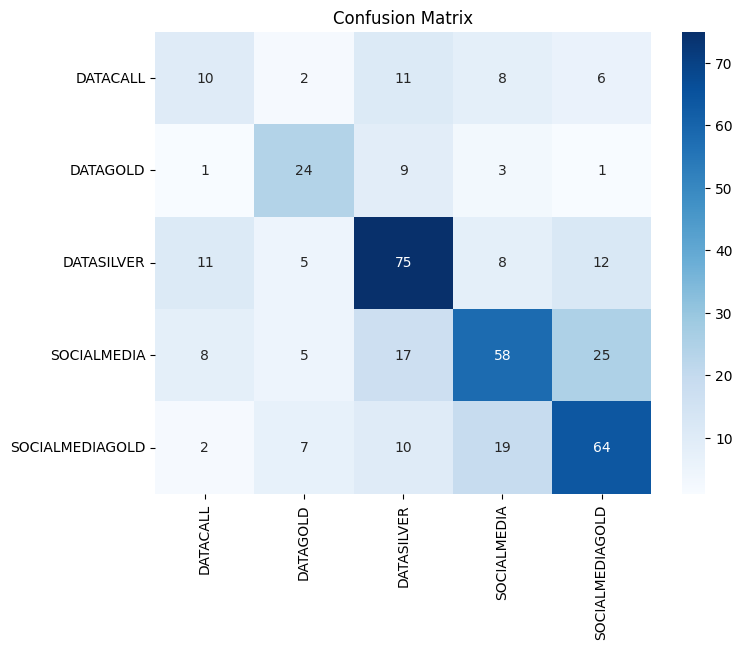

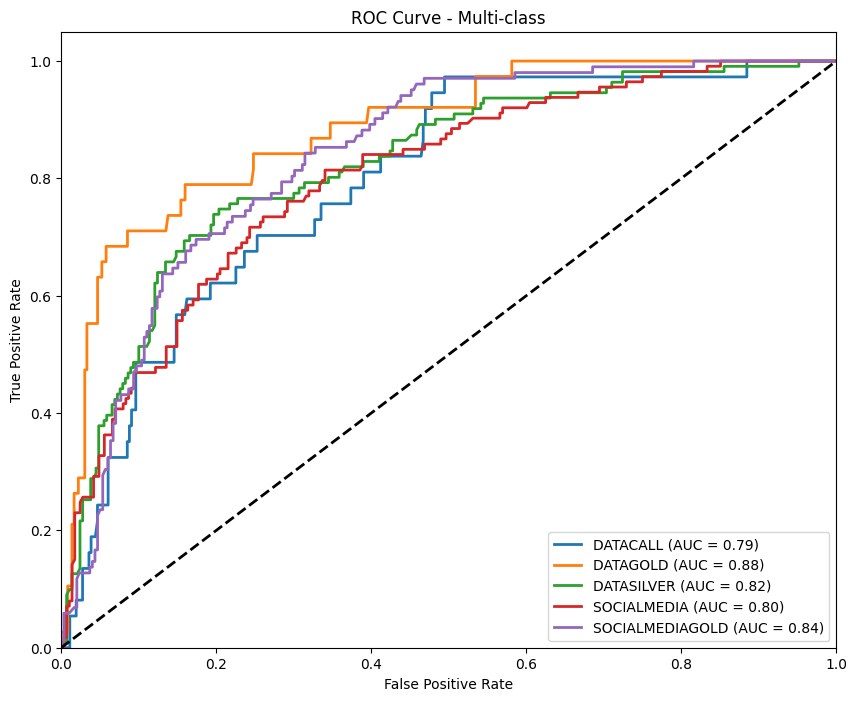

2025-12-10 18:21:07,376 - INFO - ========== Running model: rf ==========
INFO:__main__:========== Running model: rf ==========
2025-12-10 18:21:07,412 - INFO - Data loaded with shape (5382, 44)
INFO:__main__:Data loaded with shape (5382, 44)
2025-12-10 18:21:07,420 - INFO - Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'education', 'profession', 'living_with', 'nation', 'phone', 'job', 'marriage_status', 'purpose', 'go_with', 'weather', 'time', 'age_group'], Numerical cols: ['id', 'age', 'income', 'fb_freq', 'yt_freq', 'tik_freq', 'use_less_than_2GB', 'use_2GB_to_4GB', 'number_child', 'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'to_hanoi', 'to_other', 'score', 'number_of_suggestions', 'number_of_plans', 'number_of_accept', 'number_of_accept_2', 'freq', 'accept_rate', 'Smaller_than_6M', '6M_to_12M', '12M_to_20M', 'Higher_than_20M', 'time_morning', 'time_afternoon', 'time_evening', 'time_night'], Scaler applied: False
INFO:__main__:Pr


===== Running model: rf =====


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
2025-12-10 18:21:09,372 - INFO - Training completed in 1.90 seconds.
INFO:__main__:Training completed in 1.90 seconds.
2025-12-10 18:21:09,374 - INFO - Hyperparameter search started. Method=GRID, Scoring=f1_macro
INFO:__main__:Hyperparameter search started. Method=GRID, Scoring=f1_macro


Fitting 1 folds for each of 81 candidates, totalling 81 fits


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
2025-12-10 18:23:35,869 - INFO - Hyperparameter optimization completed. Best params: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
INFO:__main__:Hyperparameter optimization completed. Best params: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
2025-12-10 18:23:35,873 - INFO - Retraining rf on full train+val with best params...
INFO:__main__:Retraining rf on full train+val with best params...
/usr/local/lib/python3.12/dist-packa

Best params: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}


2025-12-10 18:23:39,002 - INFO - rf retrained on full train+val successfully.
INFO:__main__:rf retrained on full train+val successfully.
2025-12-10 18:23:39,007 - INFO - Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'education', 'profession', 'living_with', 'nation', 'phone', 'job', 'marriage_status', 'purpose', 'go_with', 'weather', 'time', 'age_group'], Numerical cols: ['id', 'age', 'income', 'fb_freq', 'yt_freq', 'tik_freq', 'use_less_than_2GB', 'use_2GB_to_4GB', 'number_child', 'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'to_hanoi', 'to_other', 'score', 'number_of_suggestions', 'number_of_plans', 'number_of_accept', 'number_of_accept_2', 'freq', 'accept_rate', 'Smaller_than_6M', '6M_to_12M', '12M_to_20M', 'Higher_than_20M', 'time_morning', 'time_afternoon', 'time_evening', 'time_night'], Scaler applied: False
INFO:__main__:Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'education'

Accuracy: 0.613, F1-macro: 0.602, Precision: 0.601, Recall: 0.608
                 precision    recall  f1-score   support

       DATACALL       0.43      0.49      0.46        37
       DATAGOLD       0.68      0.68      0.68        38
     DATASILVER       0.65      0.64      0.65       111
    SOCIALMEDIA       0.64      0.51      0.57       113
SOCIALMEDIAGOLD       0.60      0.72      0.65       102

       accuracy                           0.61       401
      macro avg       0.60      0.61      0.60       401
   weighted avg       0.62      0.61      0.61       401



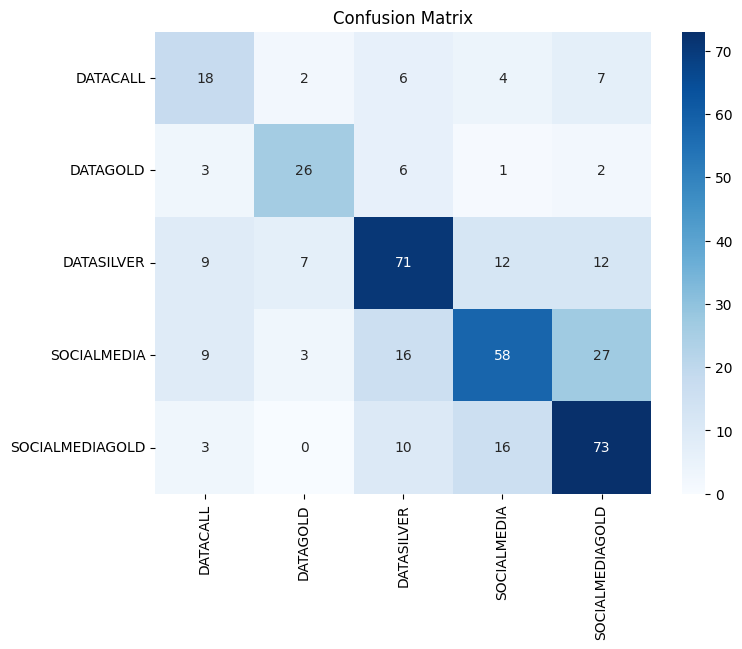

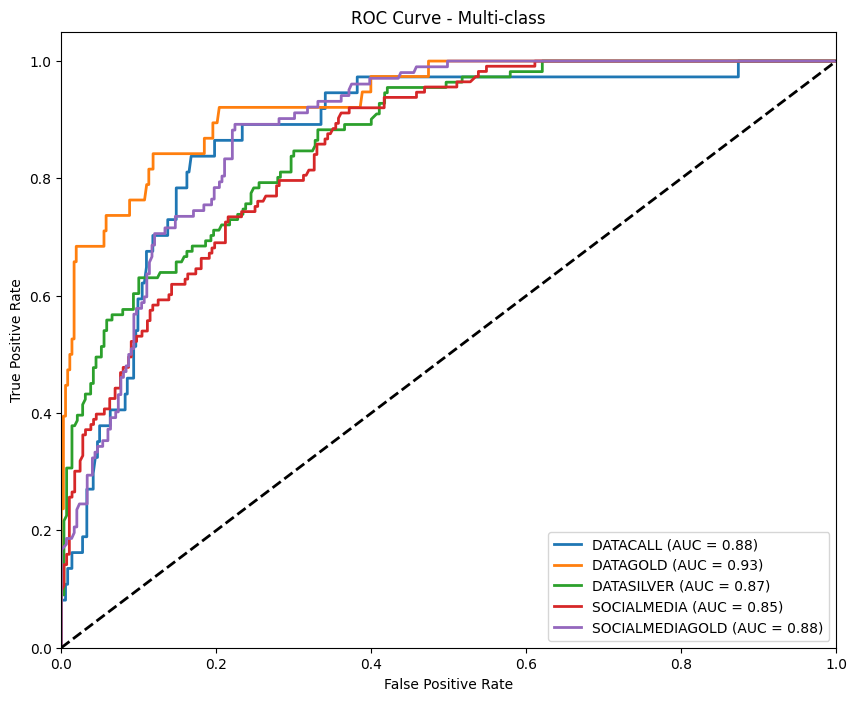

2025-12-10 18:23:39,597 - INFO - ========== Running model: lgbm ==========
INFO:__main__:========== Running model: lgbm ==========
2025-12-10 18:23:39,639 - INFO - Data loaded with shape (5382, 44)
INFO:__main__:Data loaded with shape (5382, 44)
2025-12-10 18:23:39,649 - INFO - Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'education', 'profession', 'living_with', 'nation', 'phone', 'job', 'marriage_status', 'purpose', 'go_with', 'weather', 'time', 'age_group'], Numerical cols: ['id', 'age', 'income', 'fb_freq', 'yt_freq', 'tik_freq', 'use_less_than_2GB', 'use_2GB_to_4GB', 'number_child', 'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'to_hanoi', 'to_other', 'score', 'number_of_suggestions', 'number_of_plans', 'number_of_accept', 'number_of_accept_2', 'freq', 'accept_rate', 'Smaller_than_6M', '6M_to_12M', '12M_to_20M', 'Higher_than_20M', 'time_morning', 'time_afternoon', 'time_evening', 'time_night'], Scaler applied: False
INFO:__main_


===== Running model: lgbm =====
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 182
[LightGBM] [Info] Number of data points in the train set: 2250, number of used features: 37
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
2025-12-10 18:23:40,124 - INFO - Training completed in 0.42 seconds.
INFO:__main__:Training completed in 0.42 seconds.
2025-12-10 18:23:40,127 - INFO - Hyperparameter search started. Method=GRID, Scoring=f1_macro
INFO:__main__:Hyperparameter search started. Method=GRID, Scoring=f1_macro


Fitting 1 folds for each of 81 candidates, totalling 81 fits


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 134
[LightGBM] [Info] Number of data points in the train set: 3327, number of used features: 39
[LightGBM] [Info] Start training from score -1.738214
[LightGBM] [Info] Start training from score -1.776547
[LightGBM] [Info] Start training from score -1.511317
[LightGBM] [Info] Start training from score -1.503176
[LightGBM] [Info] Start training from score -1.551628


2025-12-10 18:25:20,656 - INFO - Hyperparameter optimization completed. Best params: {'classifier__learning_rate': 0.05, 'classifier__max_depth': -1, 'classifier__n_estimators': 300, 'classifier__num_leaves': 20}
INFO:__main__:Hyperparameter optimization completed. Best params: {'classifier__learning_rate': 0.05, 'classifier__max_depth': -1, 'classifier__n_estimators': 300, 'classifier__num_leaves': 20}
2025-12-10 18:25:20,660 - INFO - Retraining lgbm on full train+val with best params...
INFO:__main__:Retraining lgbm on full train+val with best params...
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best params: {'classifier__learning_rate': 0.05, 'classifier__max_depth': -1, 'classifier__n_estimators': 300, 'classifier__num_leaves': 20}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 134
[LightGBM] [Info] Number of data points in the train set: 3327, number of used features: 39
[LightGBM] [Info] Start training from score -1.738214
[LightGBM] [Info] Start training from score -1.776547
[LightGBM] [Info] Start training from score -1.511317
[LightGBM] [Info] Start training from score -1.503176
[LightGBM] [Info] Start training from score -1.551628


2025-12-10 18:25:21,624 - INFO - lgbm retrained on full train+val successfully.
INFO:__main__:lgbm retrained on full train+val successfully.
2025-12-10 18:25:21,630 - INFO - Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'education', 'profession', 'living_with', 'nation', 'phone', 'job', 'marriage_status', 'purpose', 'go_with', 'weather', 'time', 'age_group'], Numerical cols: ['id', 'age', 'income', 'fb_freq', 'yt_freq', 'tik_freq', 'use_less_than_2GB', 'use_2GB_to_4GB', 'number_child', 'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'to_hanoi', 'to_other', 'score', 'number_of_suggestions', 'number_of_plans', 'number_of_accept', 'number_of_accept_2', 'freq', 'accept_rate', 'Smaller_than_6M', '6M_to_12M', '12M_to_20M', 'Higher_than_20M', 'time_morning', 'time_afternoon', 'time_evening', 'time_night'], Scaler applied: False
INFO:__main__:Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'educat

Accuracy: 0.599, F1-macro: 0.579, Precision: 0.585, Recall: 0.579
                 precision    recall  f1-score   support

       DATACALL       0.38      0.43      0.41        37
       DATAGOLD       0.70      0.61      0.65        38
     DATASILVER       0.67      0.70      0.68       111
    SOCIALMEDIA       0.60      0.49      0.54       113
SOCIALMEDIAGOLD       0.58      0.67      0.62       102

       accuracy                           0.60       401
      macro avg       0.58      0.58      0.58       401
   weighted avg       0.60      0.60      0.60       401



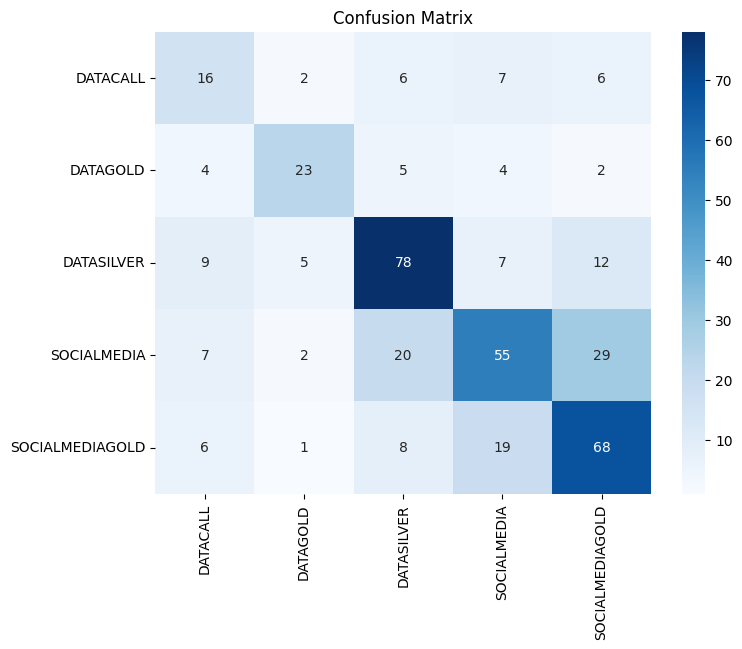

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


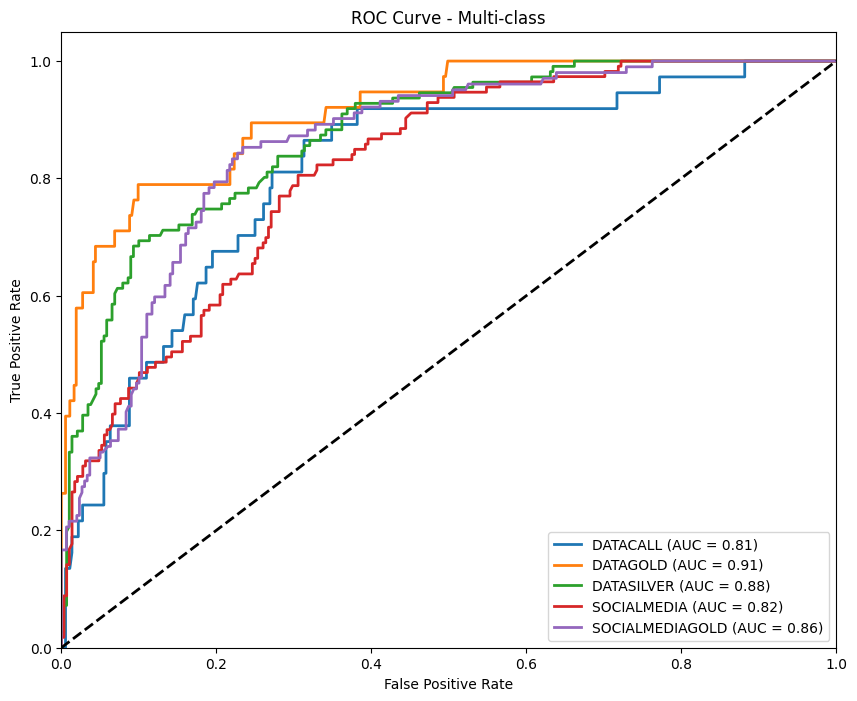

2025-12-10 18:25:22,283 - INFO - ========== Running model: xgb ==========
INFO:__main__:========== Running model: xgb ==========
2025-12-10 18:25:22,326 - INFO - Data loaded with shape (5382, 44)
INFO:__main__:Data loaded with shape (5382, 44)
2025-12-10 18:25:22,336 - INFO - Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'education', 'profession', 'living_with', 'nation', 'phone', 'job', 'marriage_status', 'purpose', 'go_with', 'weather', 'time', 'age_group'], Numerical cols: ['id', 'age', 'income', 'fb_freq', 'yt_freq', 'tik_freq', 'use_less_than_2GB', 'use_2GB_to_4GB', 'number_child', 'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'to_hanoi', 'to_other', 'score', 'number_of_suggestions', 'number_of_plans', 'number_of_accept', 'number_of_accept_2', 'freq', 'accept_rate', 'Smaller_than_6M', '6M_to_12M', '12M_to_20M', 'Higher_than_20M', 'time_morning', 'time_afternoon', 'time_evening', 'time_night'], Scaler applied: False
INFO:__main__:


===== Running model: xgb =====


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
2025-12-10 18:25:23,241 - INFO - Training completed in 0.86 seconds.
INFO:__main__:Training completed in 0.86 seconds.
2025-12-10 18:25:23,245 - INFO - Hyperparameter search started. Method=GRID, Scoring=f1_macro
INFO:__main__:Hyperparameter search started. Method=GRID, Scoring=f1_macro


Fitting 1 folds for each of 108 candidates, totalling 108 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
2025-12-10 18:28:06,578 - INFO - Hyperparameter optimization completed. Best params: {'classifier__colsample_bytree': 0.7, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 6, 'classifier__n_estimators': 100, 'classifier__subsample': 0.9}
INFO:__main__:Hyperparameter optimization completed. Best params: {'classifier__colsample_bytree': 0.7, 'classi

Best params: {'classifier__colsample_bytree': 0.7, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 6, 'classifier__n_estimators': 100, 'classifier__subsample': 0.9}


2025-12-10 18:28:08,588 - INFO - xgb retrained on full train+val successfully.
INFO:__main__:xgb retrained on full train+val successfully.
2025-12-10 18:28:08,597 - INFO - Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'education', 'profession', 'living_with', 'nation', 'phone', 'job', 'marriage_status', 'purpose', 'go_with', 'weather', 'time', 'age_group'], Numerical cols: ['id', 'age', 'income', 'fb_freq', 'yt_freq', 'tik_freq', 'use_less_than_2GB', 'use_2GB_to_4GB', 'number_child', 'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'to_hanoi', 'to_other', 'score', 'number_of_suggestions', 'number_of_plans', 'number_of_accept', 'number_of_accept_2', 'freq', 'accept_rate', 'Smaller_than_6M', '6M_to_12M', '12M_to_20M', 'Higher_than_20M', 'time_morning', 'time_afternoon', 'time_evening', 'time_night'], Scaler applied: False
INFO:__main__:Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'educatio

Accuracy: 0.606, F1-macro: 0.593, Precision: 0.593, Recall: 0.605
                 precision    recall  f1-score   support

       DATACALL       0.37      0.49      0.42        37
       DATAGOLD       0.69      0.71      0.70        38
     DATASILVER       0.62      0.72      0.67       111
    SOCIALMEDIA       0.66      0.45      0.54       113
SOCIALMEDIAGOLD       0.62      0.66      0.64       102

       accuracy                           0.61       401
      macro avg       0.59      0.61      0.59       401
   weighted avg       0.62      0.61      0.60       401



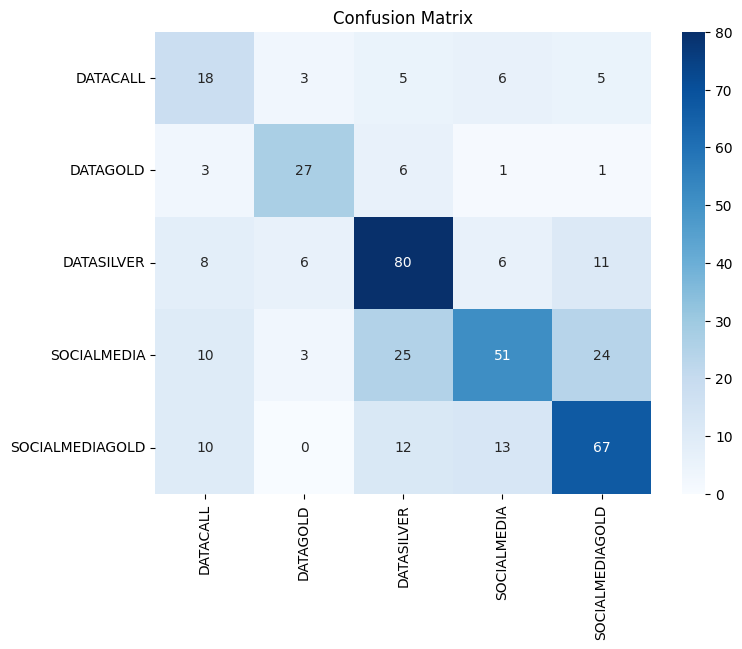

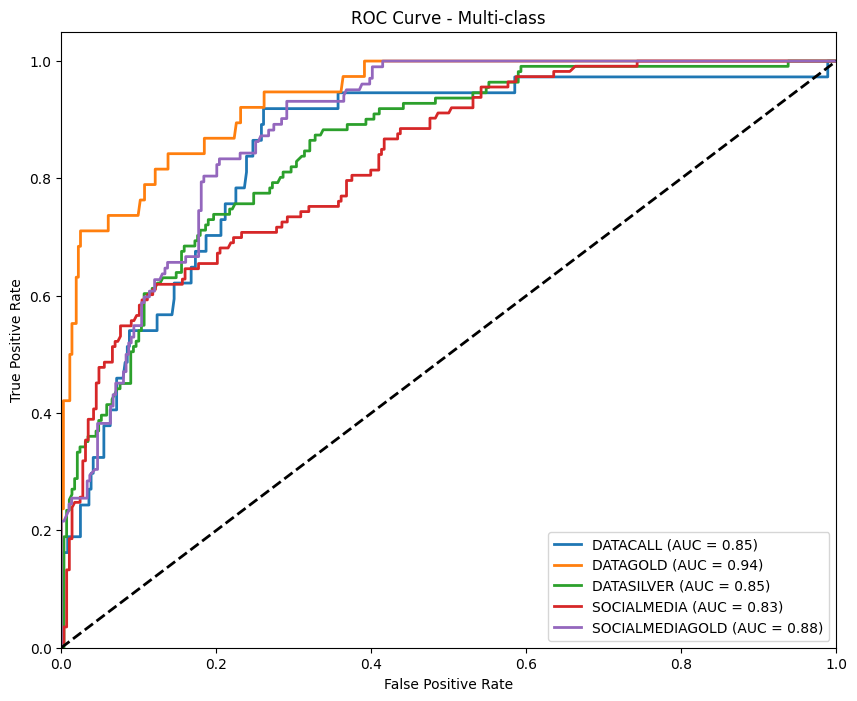

2025-12-10 18:28:09,447 - INFO - ========== Running model: cat ==========
INFO:__main__:========== Running model: cat ==========
2025-12-10 18:28:09,487 - INFO - Data loaded with shape (5382, 44)
INFO:__main__:Data loaded with shape (5382, 44)
2025-12-10 18:28:09,497 - INFO - Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'education', 'profession', 'living_with', 'nation', 'phone', 'job', 'marriage_status', 'purpose', 'go_with', 'weather', 'time', 'age_group'], Numerical cols: ['id', 'age', 'income', 'fb_freq', 'yt_freq', 'tik_freq', 'use_less_than_2GB', 'use_2GB_to_4GB', 'number_child', 'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'to_hanoi', 'to_other', 'score', 'number_of_suggestions', 'number_of_plans', 'number_of_accept', 'number_of_accept_2', 'freq', 'accept_rate', 'Smaller_than_6M', '6M_to_12M', '12M_to_20M', 'Higher_than_20M', 'time_morning', 'time_afternoon', 'time_evening', 'time_night'], Scaler applied: False
INFO:__main__:


===== Running model: cat =====


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
2025-12-10 18:28:16,244 - INFO - Training completed in 6.69 seconds.
INFO:__main__:Training completed in 6.69 seconds.
2025-12-10 18:28:16,246 - INFO - Hyperparameter search started. Method=GRID, Scoring=f1_macro
INFO:__main__:Hyperparameter search started. Method=GRID, Scoring=f1_macro


Fitting 1 folds for each of 81 candidates, totalling 81 fits


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
2025-12-10 18:33:17,077 - INFO - Hyperparameter optimization completed. Best params: {'classifier__depth': 8, 'classifier__iterations': 100, 'classifier__l2_leaf_reg': 5, 'classifier__learning_rate': 0.01}
INFO:__main__:Hyperparameter optimization completed. Best params: {'classifier__depth': 8, 'classifier__iterations': 100, 'classifier__l2_leaf_reg': 5, 'classifier__learning_rate': 0.01}
2025-12-10 18:33:17,081 - INFO - Retraining cat on full train+val with best params...
INFO:__main__:Retraining cat on full train+val with best params...
/usr/local/lib/python3.12/dist-packages/sklearn/feature_select

Best params: {'classifier__depth': 8, 'classifier__iterations': 100, 'classifier__l2_leaf_reg': 5, 'classifier__learning_rate': 0.01}


2025-12-10 18:33:19,327 - INFO - cat retrained on full train+val successfully.
INFO:__main__:cat retrained on full train+val successfully.
2025-12-10 18:33:19,333 - INFO - Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'education', 'profession', 'living_with', 'nation', 'phone', 'job', 'marriage_status', 'purpose', 'go_with', 'weather', 'time', 'age_group'], Numerical cols: ['id', 'age', 'income', 'fb_freq', 'yt_freq', 'tik_freq', 'use_less_than_2GB', 'use_2GB_to_4GB', 'number_child', 'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'to_hanoi', 'to_other', 'score', 'number_of_suggestions', 'number_of_plans', 'number_of_accept', 'number_of_accept_2', 'freq', 'accept_rate', 'Smaller_than_6M', '6M_to_12M', '12M_to_20M', 'Higher_than_20M', 'time_morning', 'time_afternoon', 'time_evening', 'time_night'], Scaler applied: False
INFO:__main__:Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'educatio

Accuracy: 0.546, F1-macro: 0.554, Precision: 0.562, Recall: 0.583
                 precision    recall  f1-score   support

       DATACALL       0.32      0.65      0.43        37
       DATAGOLD       0.73      0.71      0.72        38
     DATASILVER       0.55      0.63      0.59       111
    SOCIALMEDIA       0.61      0.35      0.44       113
SOCIALMEDIAGOLD       0.60      0.58      0.59       102

       accuracy                           0.55       401
      macro avg       0.56      0.58      0.55       401
   weighted avg       0.58      0.55      0.54       401



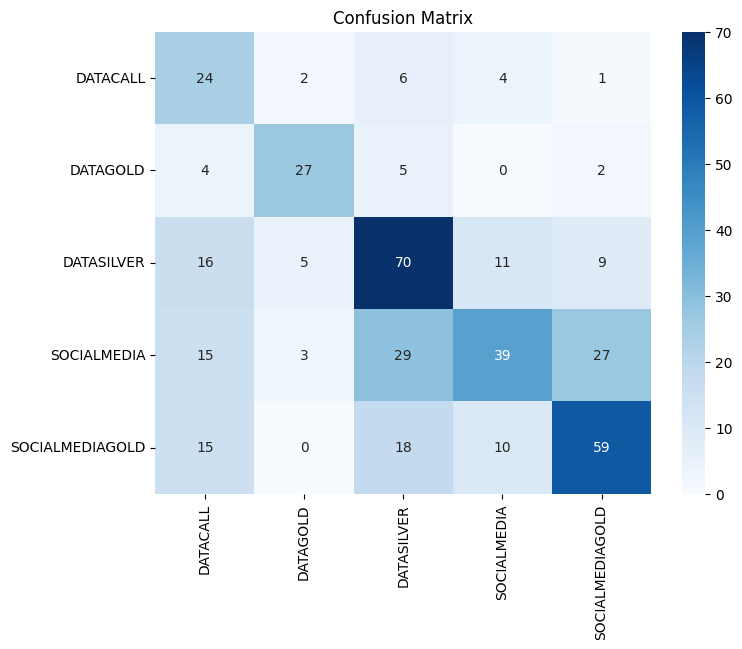

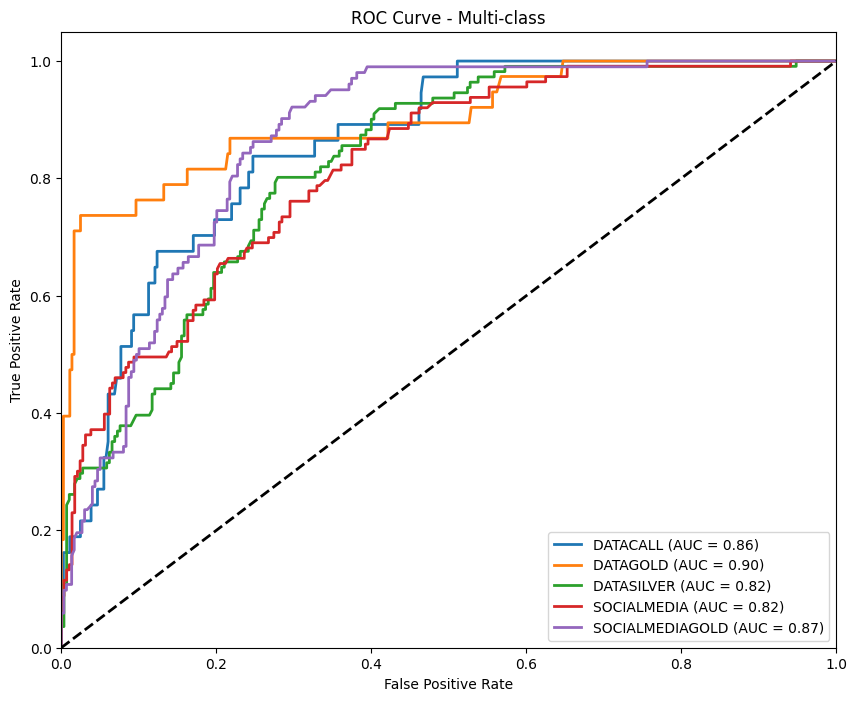

Results saved to result_grid.csv

===== All models results =====
lr: {'accuracy': 0.428927680798005, 'f1_macro': 0.3900651412079984, 'precision': 0.4145344270571131, 'recall': 0.38642500140075414}
svm: {'accuracy': 0.5760598503740648, 'f1_macro': 0.5381544444118963, 'precision': 0.5364305785007272, 'recall': 0.5436500419979419}
rf: {'accuracy': 0.6134663341645885, 'f1_macro': 0.6017394490923491, 'precision': 0.6009653048325626, 'recall': 0.607859452646981}
lgbm: {'accuracy': 0.5985037406483791, 'f1_macro': 0.5789502146924792, 'precision': 0.5847222825483696, 'recall': 0.5787581246826705}
xgb: {'accuracy': 0.6059850374064838, 'f1_macro': 0.592859352553099, 'precision': 0.593472532758247, 'recall': 0.6051847403446077}
cat: {'accuracy': 0.5461346633416458, 'f1_macro': 0.5537768914223066, 'precision': 0.5624689740761168, 'recall': 0.5826739421961209}


In [ ]:
# Chạy tất cả các mô hình với tập train và test với phương pháp selection là Kbest và phương pháp optimize là grid search

print("Kết quả chạy tất cả các mô hình với phương pháp grid_search và SelectKbest:")

results = trainer.run_models(
    df_train, df_test,
    target_col='mobile_plan',
    models=models_to_try,
    k_best=40,
    param_grids=param_grids_all_models,   # Pass the dictionary of model-specific param_grids
    search="grid",
    save_path = "result_grid.csv"
)



2025-12-10 18:33:40,308 - INFO - ========== Running model: lr ==========
INFO:__main__:========== Running model: lr ==========
2025-12-10 18:33:40,338 - INFO - Data loaded with shape (5382, 44)
INFO:__main__:Data loaded with shape (5382, 44)
2025-12-10 18:33:40,346 - INFO - Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'education', 'profession', 'living_with', 'nation', 'phone', 'job', 'marriage_status', 'purpose', 'go_with', 'weather', 'time', 'age_group'], Numerical cols: ['id', 'age', 'income', 'fb_freq', 'yt_freq', 'tik_freq', 'use_less_than_2GB', 'use_2GB_to_4GB', 'number_child', 'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'to_hanoi', 'to_other', 'score', 'number_of_suggestions', 'number_of_plans', 'number_of_accept', 'number_of_accept_2', 'freq', 'accept_rate', 'Smaller_than_6M', '6M_to_12M', '12M_to_20M', 'Higher_than_20M', 'time_morning', 'time_afternoon', 'time_evening', 'time_night'], Scaler applied: True
INFO:__main__:Pre

Kết quả chạy tất cả các mô hình với phương pháp randomize_search và SelectKbest:

===== Running model: lr =====


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
2025-12-10 18:33:40,556 - INFO - Training completed in 0.17 seconds.
INFO:__main__:Training completed in 0.17 seconds.
2025-12-10 18:33:40,559 - INFO - Hyperparameter search started. Method=RANDOM, Scoring=f1_macro
INFO:__main__:Hyperparameter search started. Method=RANDOM, Scoring=f1_macro
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 1 folds for each of 4 candidates, totalling 4 fits


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
2025-12-10 18:33:41,545 - INFO - Hyperparameter optimization completed. Best params: {'classifier__solver': 'lbfgs', 'classifier__max_iter': 500, 'classifier__C': 0.1}
INFO:__main__:Hyperparameter optimization completed. Best params: {'classifier__solver': 'lbfgs', 'classifier__max_iter': 500, 'classifier__C': 0.1}
2025-12-10 18:33:41,552 - INFO - Retraining lr on full train+val with best params...
INFO:__main__:Retraining lr on full train+val with best params...
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0 0 0 0 0 0] are cons

Best params: {'classifier__solver': 'lbfgs', 'classifier__max_iter': 500, 'classifier__C': 0.1}


2025-12-10 18:33:41,777 - INFO - lr retrained on full train+val successfully.
INFO:__main__:lr retrained on full train+val successfully.
2025-12-10 18:33:41,784 - INFO - Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'education', 'profession', 'living_with', 'nation', 'phone', 'job', 'marriage_status', 'purpose', 'go_with', 'weather', 'time', 'age_group'], Numerical cols: ['id', 'age', 'income', 'fb_freq', 'yt_freq', 'tik_freq', 'use_less_than_2GB', 'use_2GB_to_4GB', 'number_child', 'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'to_hanoi', 'to_other', 'score', 'number_of_suggestions', 'number_of_plans', 'number_of_accept', 'number_of_accept_2', 'freq', 'accept_rate', 'Smaller_than_6M', '6M_to_12M', '12M_to_20M', 'Higher_than_20M', 'time_morning', 'time_afternoon', 'time_evening', 'time_night'], Scaler applied: True
INFO:__main__:Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'education',

Accuracy: 0.429, F1-macro: 0.390, Precision: 0.415, Recall: 0.386
                 precision    recall  f1-score   support

       DATACALL       0.39      0.19      0.25        37
       DATAGOLD       0.33      0.34      0.34        38
     DATASILVER       0.60      0.61      0.60       111
    SOCIALMEDIA       0.43      0.33      0.37       113
SOCIALMEDIAGOLD       0.33      0.46      0.38       102

       accuracy                           0.43       401
      macro avg       0.41      0.39      0.39       401
   weighted avg       0.44      0.43      0.42       401



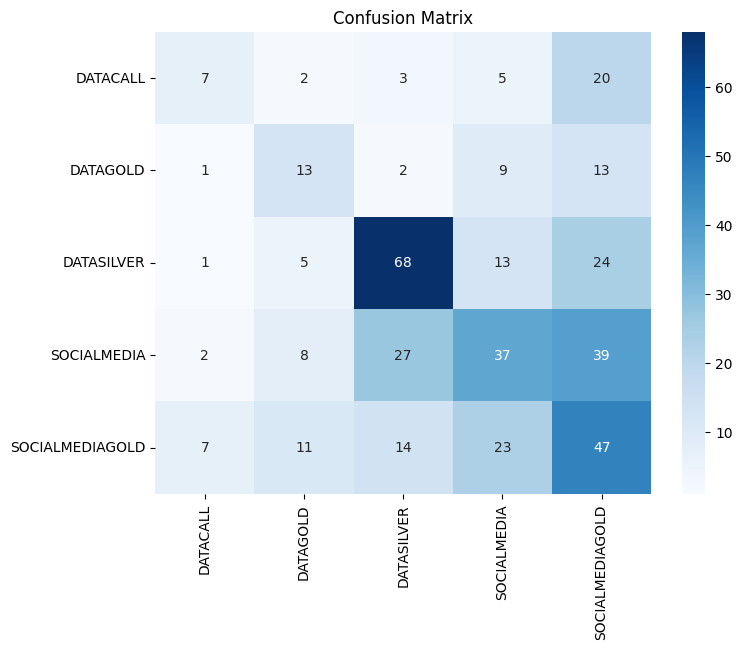

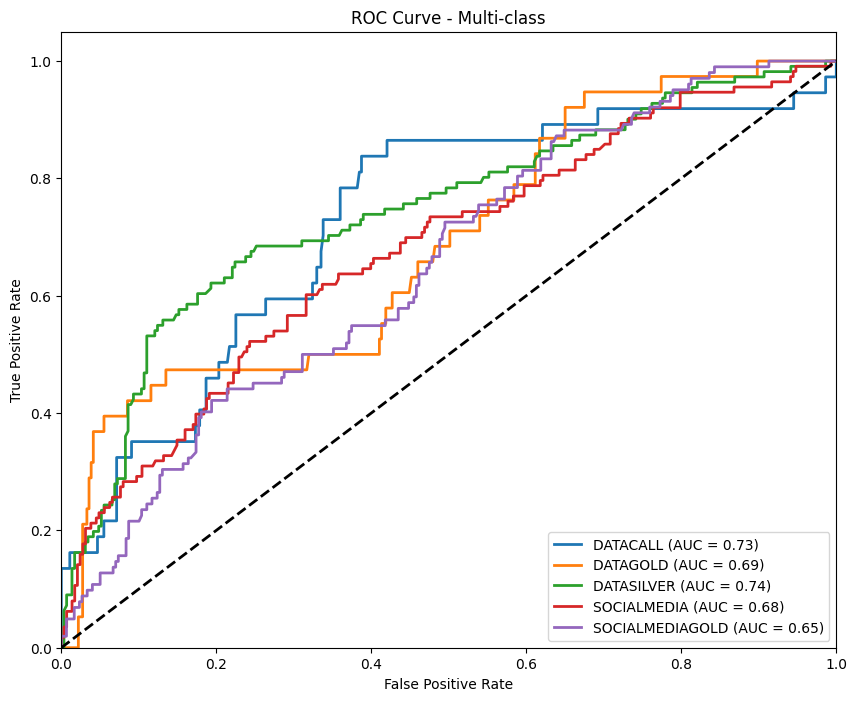

2025-12-10 18:33:42,527 - INFO - ========== Running model: svm ==========
INFO:__main__:========== Running model: svm ==========
2025-12-10 18:33:42,569 - INFO - Data loaded with shape (5382, 44)
INFO:__main__:Data loaded with shape (5382, 44)
2025-12-10 18:33:42,578 - INFO - Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'education', 'profession', 'living_with', 'nation', 'phone', 'job', 'marriage_status', 'purpose', 'go_with', 'weather', 'time', 'age_group'], Numerical cols: ['id', 'age', 'income', 'fb_freq', 'yt_freq', 'tik_freq', 'use_less_than_2GB', 'use_2GB_to_4GB', 'number_child', 'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'to_hanoi', 'to_other', 'score', 'number_of_suggestions', 'number_of_plans', 'number_of_accept', 'number_of_accept_2', 'freq', 'accept_rate', 'Smaller_than_6M', '6M_to_12M', '12M_to_20M', 'Higher_than_20M', 'time_morning', 'time_afternoon', 'time_evening', 'time_night'], Scaler applied: True
INFO:__main__:P


===== Running model: svm =====


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
2025-12-10 18:33:45,086 - INFO - Training completed in 2.46 seconds.
INFO:__main__:Training completed in 2.46 seconds.
2025-12-10 18:33:45,088 - INFO - Hyperparameter search started. Method=RANDOM, Scoring=f1_macro
INFO:__main__:Hyperparameter search started. Method=RANDOM, Scoring=f1_macro
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=20. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 1 folds for each of 9 candidates, totalling 9 fits


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
2025-12-10 18:34:14,866 - INFO - Hyperparameter optimization completed. Best params: {'classifier__kernel': 'rbf', 'classifier__gamma': 'scale', 'classifier__C': 10.0}
INFO:__main__:Hyperparameter optimization completed. Best params: {'classifier__kernel': 'rbf', 'classifier__gamma': 'scale', 'classifier__C': 10.0}
2025-12-10 18:34:14,869 - INFO - Retraining svm on full train+val with best params...
INFO:__main__:Retraining svm on full train+val with best params...
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0 0 0 0 0 0] are co

Best params: {'classifier__kernel': 'rbf', 'classifier__gamma': 'scale', 'classifier__C': 10.0}


2025-12-10 18:34:21,822 - INFO - svm retrained on full train+val successfully.
INFO:__main__:svm retrained on full train+val successfully.
2025-12-10 18:34:21,828 - INFO - Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'education', 'profession', 'living_with', 'nation', 'phone', 'job', 'marriage_status', 'purpose', 'go_with', 'weather', 'time', 'age_group'], Numerical cols: ['id', 'age', 'income', 'fb_freq', 'yt_freq', 'tik_freq', 'use_less_than_2GB', 'use_2GB_to_4GB', 'number_child', 'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'to_hanoi', 'to_other', 'score', 'number_of_suggestions', 'number_of_plans', 'number_of_accept', 'number_of_accept_2', 'freq', 'accept_rate', 'Smaller_than_6M', '6M_to_12M', '12M_to_20M', 'Higher_than_20M', 'time_morning', 'time_afternoon', 'time_evening', 'time_night'], Scaler applied: True
INFO:__main__:Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'education

Accuracy: 0.576, F1-macro: 0.538, Precision: 0.536, Recall: 0.544
                 precision    recall  f1-score   support

       DATACALL       0.31      0.27      0.29        37
       DATAGOLD       0.56      0.63      0.59        38
     DATASILVER       0.61      0.68      0.64       111
    SOCIALMEDIA       0.60      0.51      0.56       113
SOCIALMEDIAGOLD       0.59      0.63      0.61       102

       accuracy                           0.58       401
      macro avg       0.54      0.54      0.54       401
   weighted avg       0.57      0.58      0.57       401



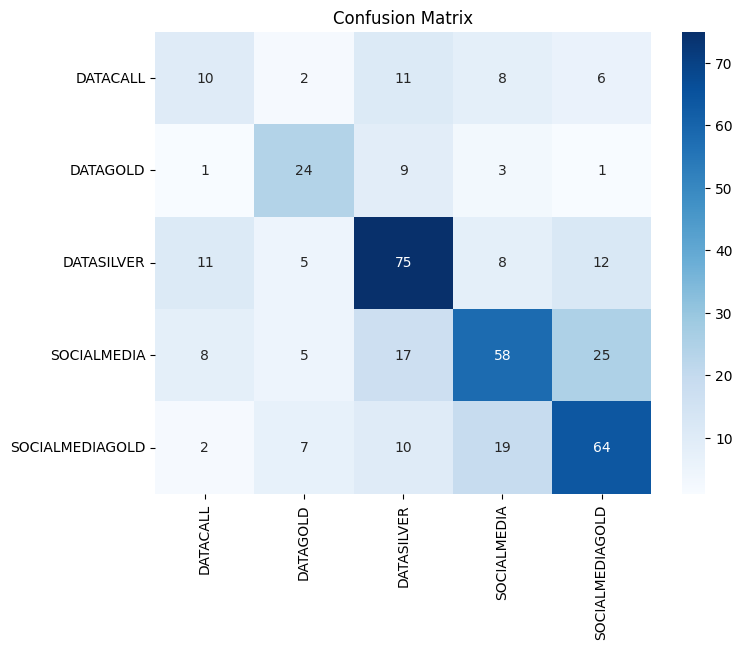

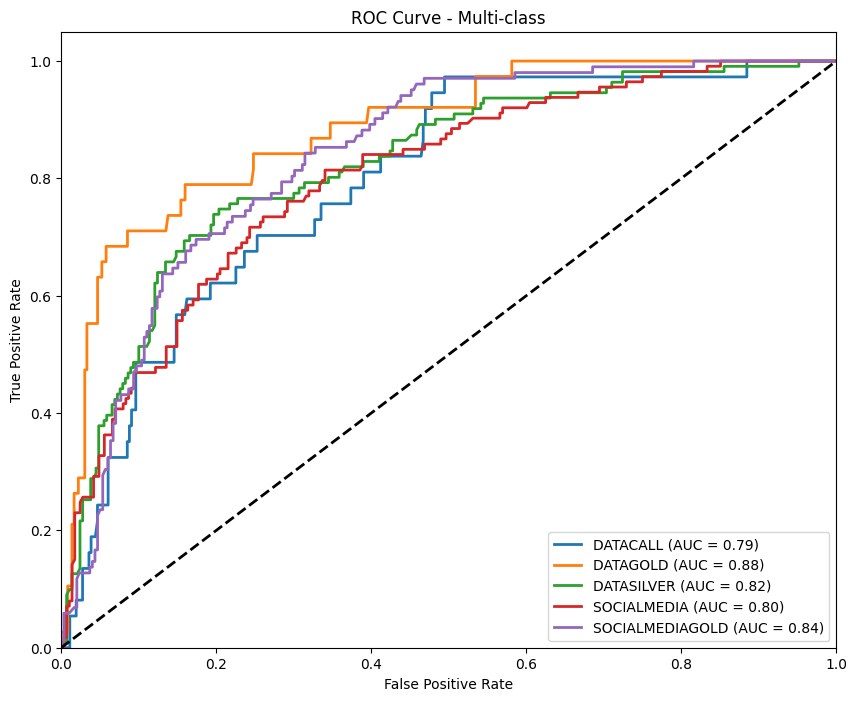

2025-12-10 18:34:22,531 - INFO - ========== Running model: rf ==========
INFO:__main__:========== Running model: rf ==========
2025-12-10 18:34:22,564 - INFO - Data loaded with shape (5382, 44)
INFO:__main__:Data loaded with shape (5382, 44)
2025-12-10 18:34:22,572 - INFO - Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'education', 'profession', 'living_with', 'nation', 'phone', 'job', 'marriage_status', 'purpose', 'go_with', 'weather', 'time', 'age_group'], Numerical cols: ['id', 'age', 'income', 'fb_freq', 'yt_freq', 'tik_freq', 'use_less_than_2GB', 'use_2GB_to_4GB', 'number_child', 'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'to_hanoi', 'to_other', 'score', 'number_of_suggestions', 'number_of_plans', 'number_of_accept', 'number_of_accept_2', 'freq', 'accept_rate', 'Smaller_than_6M', '6M_to_12M', '12M_to_20M', 'Higher_than_20M', 'time_morning', 'time_afternoon', 'time_evening', 'time_night'], Scaler applied: False
INFO:__main__:Pr


===== Running model: rf =====


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
2025-12-10 18:34:23,973 - INFO - Training completed in 1.35 seconds.
INFO:__main__:Training completed in 1.35 seconds.
2025-12-10 18:34:23,976 - INFO - Hyperparameter search started. Method=RANDOM, Scoring=f1_macro
INFO:__main__:Hyperparameter search started. Method=RANDOM, Scoring=f1_macro


Fitting 1 folds for each of 20 candidates, totalling 20 fits


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
2025-12-10 18:34:53,239 - INFO - Hyperparameter optimization completed. Best params: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 20}
INFO:__main__:Hyperparameter optimization completed. Best params: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 20}
2025-12-10 18:34:53,243 - INFO - Retraining rf on full train+val with best params...
INFO:__main__:Retraining rf on full train+val with best params...
/usr/local/lib/python3.12/dist-packa

Best params: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 20}


2025-12-10 18:34:55,747 - INFO - rf retrained on full train+val successfully.
INFO:__main__:rf retrained on full train+val successfully.
2025-12-10 18:34:55,753 - INFO - Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'education', 'profession', 'living_with', 'nation', 'phone', 'job', 'marriage_status', 'purpose', 'go_with', 'weather', 'time', 'age_group'], Numerical cols: ['id', 'age', 'income', 'fb_freq', 'yt_freq', 'tik_freq', 'use_less_than_2GB', 'use_2GB_to_4GB', 'number_child', 'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'to_hanoi', 'to_other', 'score', 'number_of_suggestions', 'number_of_plans', 'number_of_accept', 'number_of_accept_2', 'freq', 'accept_rate', 'Smaller_than_6M', '6M_to_12M', '12M_to_20M', 'Higher_than_20M', 'time_morning', 'time_afternoon', 'time_evening', 'time_night'], Scaler applied: False
INFO:__main__:Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'education'

Accuracy: 0.613, F1-macro: 0.602, Precision: 0.601, Recall: 0.608
                 precision    recall  f1-score   support

       DATACALL       0.43      0.49      0.46        37
       DATAGOLD       0.68      0.68      0.68        38
     DATASILVER       0.65      0.64      0.65       111
    SOCIALMEDIA       0.64      0.51      0.57       113
SOCIALMEDIAGOLD       0.60      0.72      0.65       102

       accuracy                           0.61       401
      macro avg       0.60      0.61      0.60       401
   weighted avg       0.62      0.61      0.61       401



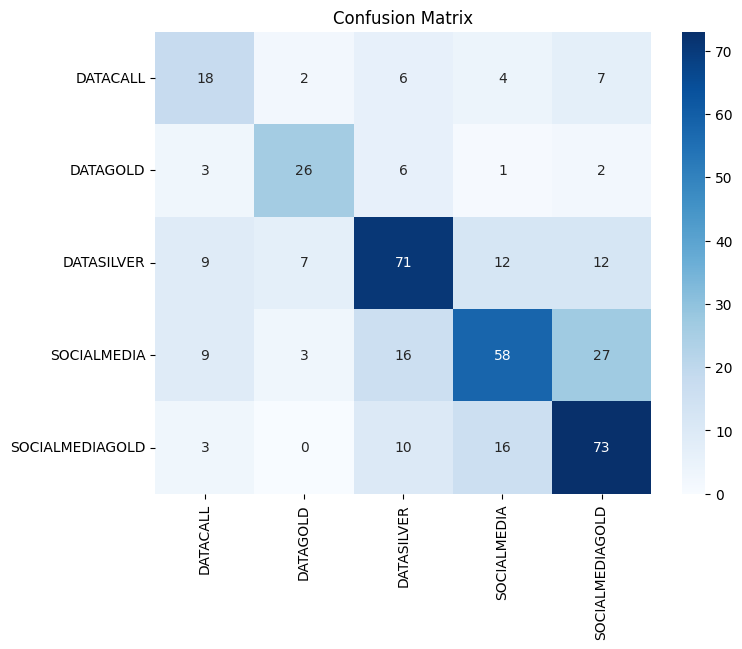

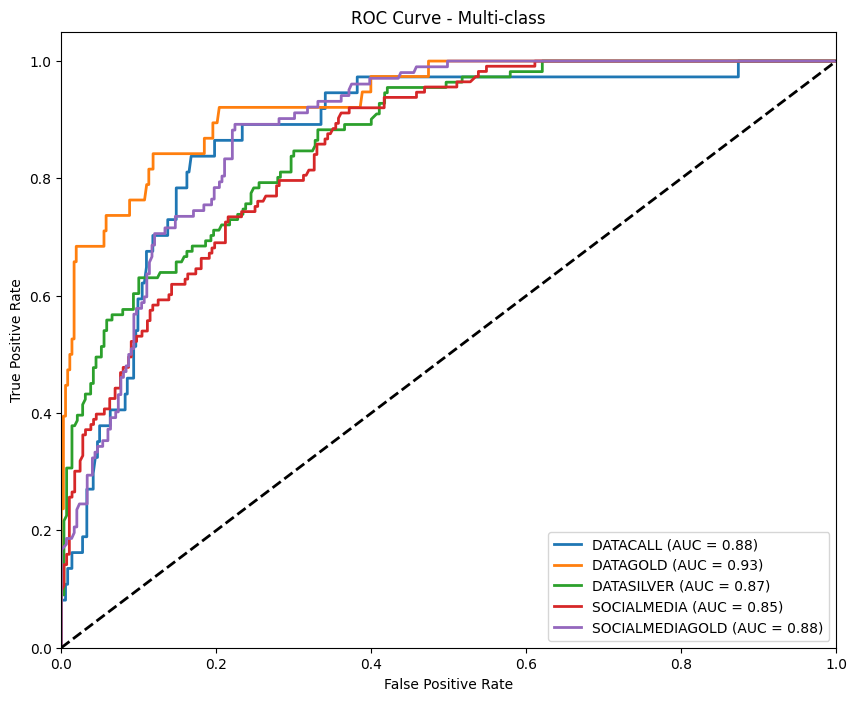

2025-12-10 18:34:56,548 - INFO - ========== Running model: lgbm ==========
INFO:__main__:========== Running model: lgbm ==========
2025-12-10 18:34:56,595 - INFO - Data loaded with shape (5382, 44)
INFO:__main__:Data loaded with shape (5382, 44)
2025-12-10 18:34:56,605 - INFO - Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'education', 'profession', 'living_with', 'nation', 'phone', 'job', 'marriage_status', 'purpose', 'go_with', 'weather', 'time', 'age_group'], Numerical cols: ['id', 'age', 'income', 'fb_freq', 'yt_freq', 'tik_freq', 'use_less_than_2GB', 'use_2GB_to_4GB', 'number_child', 'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'to_hanoi', 'to_other', 'score', 'number_of_suggestions', 'number_of_plans', 'number_of_accept', 'number_of_accept_2', 'freq', 'accept_rate', 'Smaller_than_6M', '6M_to_12M', '12M_to_20M', 'Higher_than_20M', 'time_morning', 'time_afternoon', 'time_evening', 'time_night'], Scaler applied: False
INFO:__main_


===== Running model: lgbm =====
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 182
[LightGBM] [Info] Number of data points in the train set: 2250, number of used features: 37
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
2025-12-10 18:34:57,294 - INFO - Training completed in 0.64 seconds.
INFO:__main__:Training completed in 0.64 seconds.
2025-12-10 18:34:57,297 - INFO - Hyperparameter search started. Method=RANDOM, Scoring=f1_macro
INFO:__main__:Hyperparameter search started. Method=RANDOM, Scoring=f1_macro


Fitting 1 folds for each of 20 candidates, totalling 20 fits


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 134
[LightGBM] [Info] Number of data points in the train set: 3327, number of used features: 39
[LightGBM] [Info] Start training from score -1.738214
[LightGBM] [Info] Start training from score -1.776547
[LightGBM] [Info] Start training from score -1.511317
[LightGBM] [Info] Start training from score -1.503176
[LightGBM] [Info] Start training from score -1.551628


2025-12-10 18:35:20,443 - INFO - Hyperparameter optimization completed. Best params: {'classifier__num_leaves': 20, 'classifier__n_estimators': 300, 'classifier__max_depth': -1, 'classifier__learning_rate': 0.05}
INFO:__main__:Hyperparameter optimization completed. Best params: {'classifier__num_leaves': 20, 'classifier__n_estimators': 300, 'classifier__max_depth': -1, 'classifier__learning_rate': 0.05}
2025-12-10 18:35:20,446 - INFO - Retraining lgbm on full train+val with best params...
INFO:__main__:Retraining lgbm on full train+val with best params...
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best params: {'classifier__num_leaves': 20, 'classifier__n_estimators': 300, 'classifier__max_depth': -1, 'classifier__learning_rate': 0.05}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 134
[LightGBM] [Info] Number of data points in the train set: 3327, number of used features: 39
[LightGBM] [Info] Start training from score -1.738214
[LightGBM] [Info] Start training from score -1.776547
[LightGBM] [Info] Start training from score -1.511317
[LightGBM] [Info] Start training from score -1.503176
[LightGBM] [Info] Start training from score -1.551628


2025-12-10 18:35:21,396 - INFO - lgbm retrained on full train+val successfully.
INFO:__main__:lgbm retrained on full train+val successfully.
2025-12-10 18:35:21,402 - INFO - Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'education', 'profession', 'living_with', 'nation', 'phone', 'job', 'marriage_status', 'purpose', 'go_with', 'weather', 'time', 'age_group'], Numerical cols: ['id', 'age', 'income', 'fb_freq', 'yt_freq', 'tik_freq', 'use_less_than_2GB', 'use_2GB_to_4GB', 'number_child', 'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'to_hanoi', 'to_other', 'score', 'number_of_suggestions', 'number_of_plans', 'number_of_accept', 'number_of_accept_2', 'freq', 'accept_rate', 'Smaller_than_6M', '6M_to_12M', '12M_to_20M', 'Higher_than_20M', 'time_morning', 'time_afternoon', 'time_evening', 'time_night'], Scaler applied: False
INFO:__main__:Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'educat

Accuracy: 0.599, F1-macro: 0.579, Precision: 0.585, Recall: 0.579
                 precision    recall  f1-score   support

       DATACALL       0.38      0.43      0.41        37
       DATAGOLD       0.70      0.61      0.65        38
     DATASILVER       0.67      0.70      0.68       111
    SOCIALMEDIA       0.60      0.49      0.54       113
SOCIALMEDIAGOLD       0.58      0.67      0.62       102

       accuracy                           0.60       401
      macro avg       0.58      0.58      0.58       401
   weighted avg       0.60      0.60      0.60       401



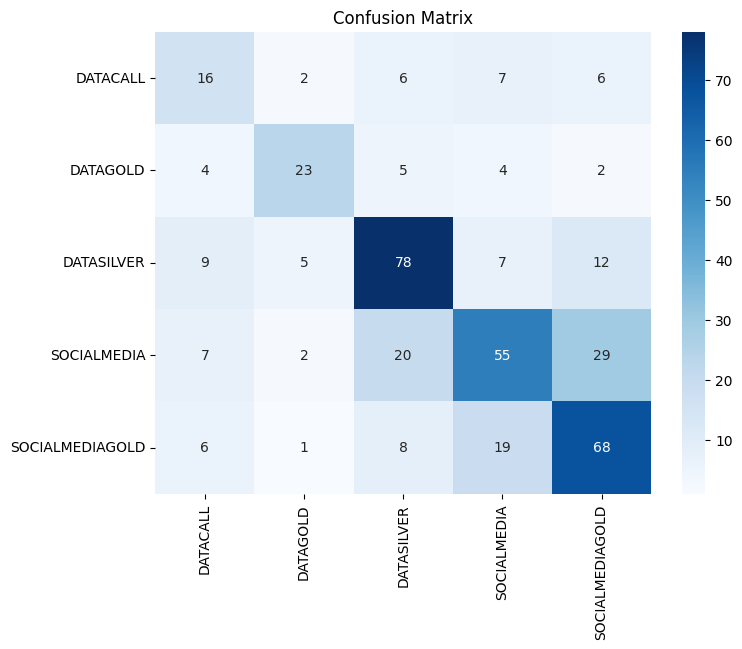

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


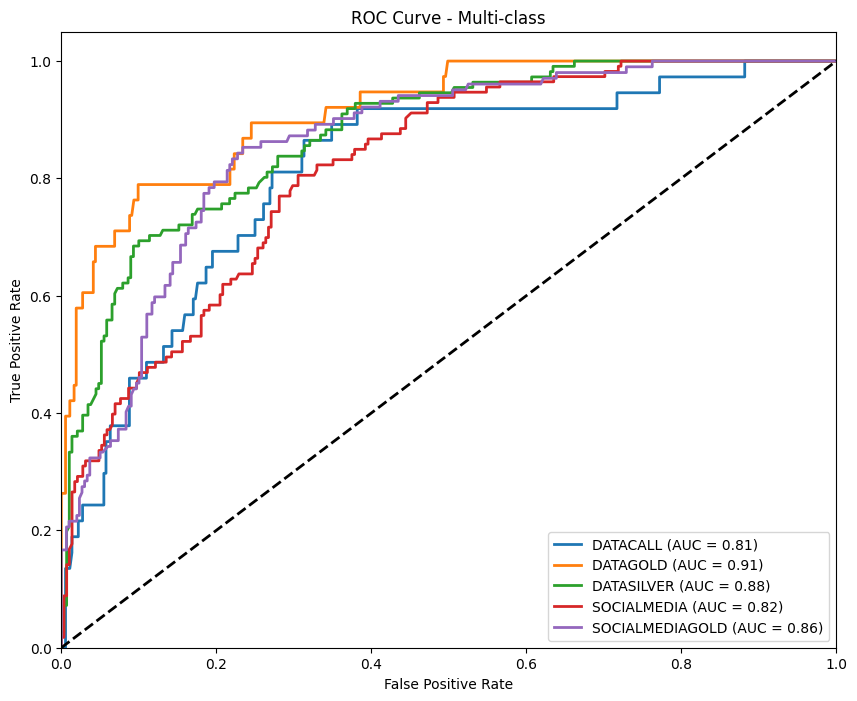

2025-12-10 18:35:22,052 - INFO - ========== Running model: xgb ==========
INFO:__main__:========== Running model: xgb ==========
2025-12-10 18:35:22,092 - INFO - Data loaded with shape (5382, 44)
INFO:__main__:Data loaded with shape (5382, 44)
2025-12-10 18:35:22,101 - INFO - Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'education', 'profession', 'living_with', 'nation', 'phone', 'job', 'marriage_status', 'purpose', 'go_with', 'weather', 'time', 'age_group'], Numerical cols: ['id', 'age', 'income', 'fb_freq', 'yt_freq', 'tik_freq', 'use_less_than_2GB', 'use_2GB_to_4GB', 'number_child', 'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'to_hanoi', 'to_other', 'score', 'number_of_suggestions', 'number_of_plans', 'number_of_accept', 'number_of_accept_2', 'freq', 'accept_rate', 'Smaller_than_6M', '6M_to_12M', '12M_to_20M', 'Higher_than_20M', 'time_morning', 'time_afternoon', 'time_evening', 'time_night'], Scaler applied: False
INFO:__main__:


===== Running model: xgb =====


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
2025-12-10 18:35:22,652 - INFO - Training completed in 0.50 seconds.
INFO:__main__:Training completed in 0.50 seconds.
2025-12-10 18:35:22,654 - INFO - Hyperparameter search started. Method=RANDOM, Scoring=f1_macro
INFO:__main__:Hyperparameter search started. Method=RANDOM, Scoring=f1_macro


Fitting 1 folds for each of 20 candidates, totalling 20 fits


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
2025-12-10 18:35:48,332 - INFO - Hyperparameter optimization completed. Best params: {'classifier__subsample': 0.9, 'classifier__n_estimators': 100, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.05, 'classifier__colsample_bytree': 0.9}
INFO:__main__:Hyperparameter optimization completed. Best params: {'classifier__subsample': 0.9, 'classifier__n_estimators': 100, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.05, 'classifier__colsample_bytree': 0.9}
2025-12-10 18:35:48,337 - INFO - Retraining xgb on full train+val with best params...
INFO:__main__:Retraining xgb on full train+

Best params: {'classifier__subsample': 0.9, 'classifier__n_estimators': 100, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.05, 'classifier__colsample_bytree': 0.9}


2025-12-10 18:35:48,912 - INFO - xgb retrained on full train+val successfully.
INFO:__main__:xgb retrained on full train+val successfully.
2025-12-10 18:35:48,920 - INFO - Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'education', 'profession', 'living_with', 'nation', 'phone', 'job', 'marriage_status', 'purpose', 'go_with', 'weather', 'time', 'age_group'], Numerical cols: ['id', 'age', 'income', 'fb_freq', 'yt_freq', 'tik_freq', 'use_less_than_2GB', 'use_2GB_to_4GB', 'number_child', 'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'to_hanoi', 'to_other', 'score', 'number_of_suggestions', 'number_of_plans', 'number_of_accept', 'number_of_accept_2', 'freq', 'accept_rate', 'Smaller_than_6M', '6M_to_12M', '12M_to_20M', 'Higher_than_20M', 'time_morning', 'time_afternoon', 'time_evening', 'time_night'], Scaler applied: False
INFO:__main__:Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'educatio

Accuracy: 0.601, F1-macro: 0.582, Precision: 0.583, Recall: 0.588
                 precision    recall  f1-score   support

       DATACALL       0.38      0.41      0.39        37
       DATAGOLD       0.67      0.68      0.68        38
     DATASILVER       0.64      0.67      0.65       111
    SOCIALMEDIA       0.63      0.48      0.54       113
SOCIALMEDIAGOLD       0.59      0.71      0.64       102

       accuracy                           0.60       401
      macro avg       0.58      0.59      0.58       401
   weighted avg       0.60      0.60      0.60       401



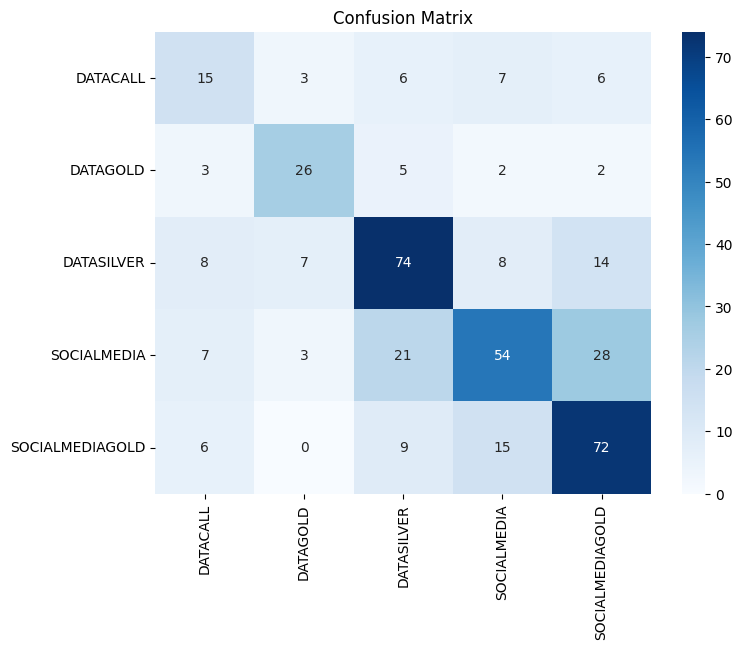

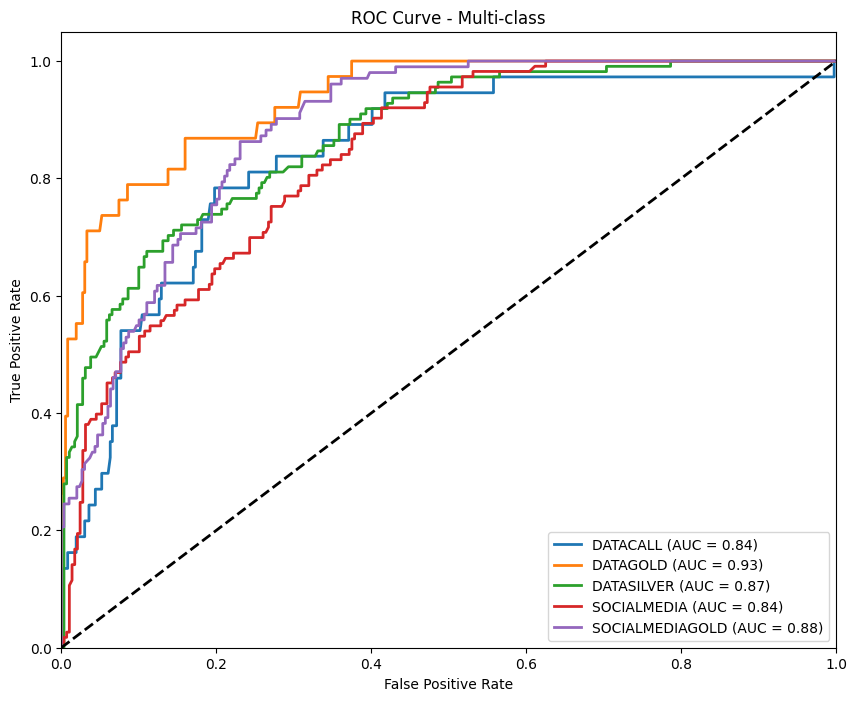

2025-12-10 18:35:49,493 - INFO - ========== Running model: cat ==========
INFO:__main__:========== Running model: cat ==========
2025-12-10 18:35:49,532 - INFO - Data loaded with shape (5382, 44)
INFO:__main__:Data loaded with shape (5382, 44)
2025-12-10 18:35:49,545 - INFO - Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'education', 'profession', 'living_with', 'nation', 'phone', 'job', 'marriage_status', 'purpose', 'go_with', 'weather', 'time', 'age_group'], Numerical cols: ['id', 'age', 'income', 'fb_freq', 'yt_freq', 'tik_freq', 'use_less_than_2GB', 'use_2GB_to_4GB', 'number_child', 'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'to_hanoi', 'to_other', 'score', 'number_of_suggestions', 'number_of_plans', 'number_of_accept', 'number_of_accept_2', 'freq', 'accept_rate', 'Smaller_than_6M', '6M_to_12M', '12M_to_20M', 'Higher_than_20M', 'time_morning', 'time_afternoon', 'time_evening', 'time_night'], Scaler applied: False
INFO:__main__:


===== Running model: cat =====


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
2025-12-10 18:35:57,720 - INFO - Training completed in 8.11 seconds.
INFO:__main__:Training completed in 8.11 seconds.
2025-12-10 18:35:57,722 - INFO - Hyperparameter search started. Method=RANDOM, Scoring=f1_macro
INFO:__main__:Hyperparameter search started. Method=RANDOM, Scoring=f1_macro


Fitting 1 folds for each of 20 candidates, totalling 20 fits


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
2025-12-10 18:37:02,791 - INFO - Hyperparameter optimization completed. Best params: {'classifier__learning_rate': 0.05, 'classifier__l2_leaf_reg': 5, 'classifier__iterations': 100, 'classifier__depth': 8}
INFO:__main__:Hyperparameter optimization completed. Best params: {'classifier__learning_rate': 0.05, 'classifier__l2_leaf_reg': 5, 'classifier__iterations': 100, 'classifier__depth': 8}
2025-12-10 18:37:02,793 - INFO - Retraining cat on full train+val with best params...
INFO:__main__:Retraining cat on full train+val with best params...
/usr/local/lib/python3.12/dist-packages/sklearn/feature_select

Best params: {'classifier__learning_rate': 0.05, 'classifier__l2_leaf_reg': 5, 'classifier__iterations': 100, 'classifier__depth': 8}


2025-12-10 18:37:05,108 - INFO - cat retrained on full train+val successfully.
INFO:__main__:cat retrained on full train+val successfully.
2025-12-10 18:37:05,115 - INFO - Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'education', 'profession', 'living_with', 'nation', 'phone', 'job', 'marriage_status', 'purpose', 'go_with', 'weather', 'time', 'age_group'], Numerical cols: ['id', 'age', 'income', 'fb_freq', 'yt_freq', 'tik_freq', 'use_less_than_2GB', 'use_2GB_to_4GB', 'number_child', 'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'to_hanoi', 'to_other', 'score', 'number_of_suggestions', 'number_of_plans', 'number_of_accept', 'number_of_accept_2', 'freq', 'accept_rate', 'Smaller_than_6M', '6M_to_12M', '12M_to_20M', 'Higher_than_20M', 'time_morning', 'time_afternoon', 'time_evening', 'time_night'], Scaler applied: False
INFO:__main__:Preprocessing created. Will be fitted inside the pipeline. Categorical cols: ['name', 'gender', 'educatio

Accuracy: 0.579, F1-macro: 0.569, Precision: 0.581, Recall: 0.576
                 precision    recall  f1-score   support

       DATACALL       0.42      0.41      0.41        37
       DATAGOLD       0.71      0.71      0.71        38
     DATASILVER       0.58      0.67      0.62       111
    SOCIALMEDIA       0.66      0.39      0.49       113
SOCIALMEDIAGOLD       0.55      0.71      0.62       102

       accuracy                           0.58       401
      macro avg       0.58      0.58      0.57       401
   weighted avg       0.59      0.58      0.57       401



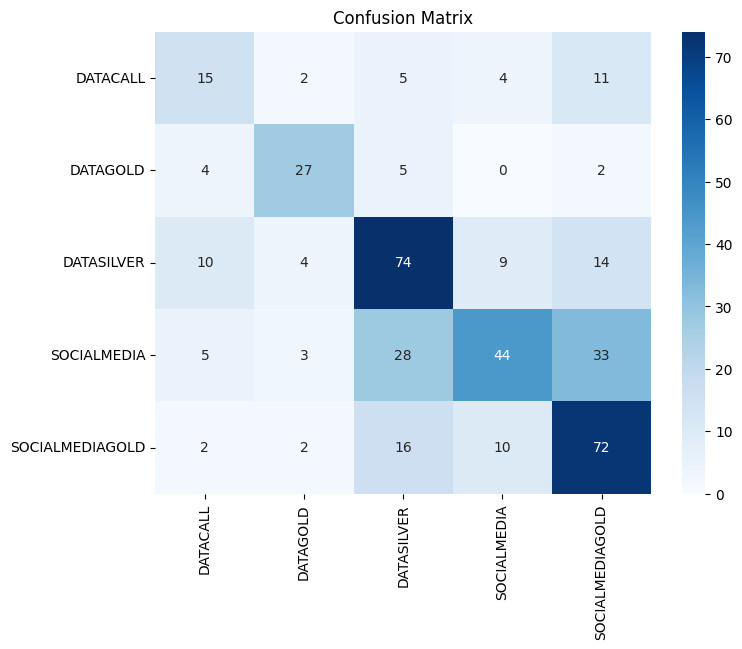

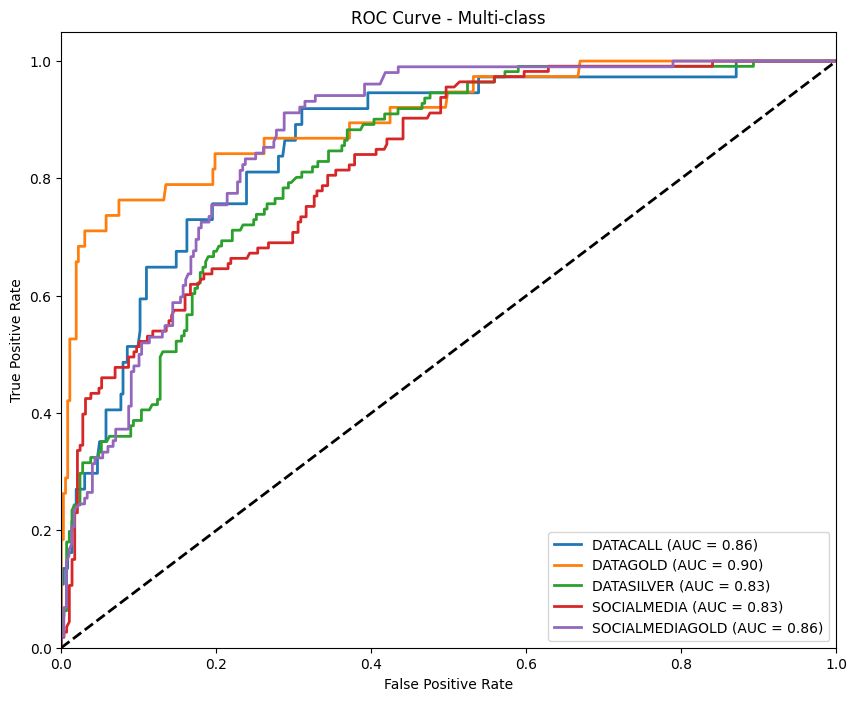

Results saved to result_random.csv

===== All models results =====
lr: {'accuracy': 0.428927680798005, 'f1_macro': 0.3900651412079984, 'precision': 0.4145344270571131, 'recall': 0.38642500140075414}
svm: {'accuracy': 0.5760598503740648, 'f1_macro': 0.5381544444118963, 'precision': 0.5364305785007272, 'recall': 0.5436500419979419}
rf: {'accuracy': 0.6134663341645885, 'f1_macro': 0.6017394490923491, 'precision': 0.6009653048325626, 'recall': 0.607859452646981}
lgbm: {'accuracy': 0.5985037406483791, 'f1_macro': 0.5789502146924792, 'precision': 0.5847222825483696, 'recall': 0.5787581246826705}
xgb: {'accuracy': 0.600997506234414, 'f1_macro': 0.5820998969526892, 'precision': 0.5825662446644063, 'recall': 0.5880082115047457}
cat: {'accuracy': 0.5785536159600998, 'f1_macro': 0.5690011172194507, 'precision': 0.5814977891642268, 'recall': 0.5755722543552347}


In [ ]:
# Chạy tất cả các mô hình với tập train và test với phương pháp selection là Kbest và phương pháp optimize là Randomizesearch

print("Kết quả chạy tất cả các mô hình với phương pháp randomize_search và SelectKbest:")
results = trainer.run_models(
    df_train, df_test,
    target_col='mobile_plan',
    models=models_to_try,
    k_best=40,
    param_grids=param_grids_all_models,  # Pass the dictionary of model-specific param_grids
    search="random",                      # Sử dụng RandomizedSearchCV thay vì GridSearchCV
    n_iter=20,                             # Số lần thử random cho mỗi model
    save_path = "result_random.csv"
)

